<h2 style='text-align: center;'>ID6002W:Online and Reinforcement Learning</h2>
<h3 style='text-align: center;'>Assignment 2 - Q1</h3>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3>

#### With 1000 Iteration

#### Importing Library

In [1]:
import gym
from gym import spaces
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm import tqdm
import time

In [2]:
np.random.seed(15)

In [3]:
start_time = time.time()

#### Common Function

In [4]:
def plot_reward_steps(avg_reward, steps, episodes, algorithm_name, goal):
    """
    Plot the average reward and number of steps per episode for a given algorithm.
    
    Parameters:
        avg_reward (list): A list of average reward values for each episode.
        steps (list): A list of number of steps for each episode.
        episodes (int): The total number of episodes.
        algorithm_name (str): The name of the algorithm to be displayed in the plot titles.
    """

    # Colors for different values of epsilon
    colors = ['g', 'r', 'k', 'b', 'y', 'm', 'c']

    # Creating a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plotting average reward
    ax1.plot(range(episodes), avg_reward, color=random.choice(colors), marker='o', linestyle='-', linewidth=2, label="Average reward")
    # Setting title, x-label and y-label for the subplot
    ax1.set_title(f'{algorithm_name} - Average Reward', fontsize=16)
    ax1.set_xlabel('Episodes', fontsize=14)
    ax1.set_ylabel('Average Reward', fontsize=14)
    # Displaying legend
    ax1.legend(loc="upper left")

    # Plotting number of steps
    ax2.plot(range(episodes), steps, color=random.choice(colors), marker='o', linestyle='-', linewidth=2, label="Steps")
    # Setting title, x-label and y-label for the subplot
    ax2.set_title(f'{algorithm_name} - Number of Steps', fontsize=16)
    ax2.set_xlabel('Episodes', fontsize=14)
    ax2.set_ylabel('Steps', fontsize=14)
    # Displaying legend
    ax2.legend(loc="upper right")

    # Adding super title for the entire figure
    fig.suptitle(f'{algorithm_name} - Learning Performance - for :{goal}', fontsize=20)

    # Displaying the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.90) # To ensure that the suptitle doesn't overlap with the subplot titles
    plt.show()   

def plot_policy(goal_pos, policy_matrix):
    """
    Plot the policy learned by the agent.

    Parameters:
        goal_pos (list): The position of the goal in the environment (format: [x, y]).
        policy_matrix (numpy.ndarray): The policy matrix representing the agent's actions at each state.
    """
    
    plt.rcParams['figure.figsize'] = [7, 7]
    fig, ax = plt.subplots()
    colors = ['#279259', '#00FF7F', '#00ff00', '#15B01A']
    random_colors = random.sample(colors, 4)

    # Define a custom color map for the policy plot     
    cmap = mcolors.ListedColormap(random_colors)
    # Display the policy matrix as a heatmap with the custom color map
    ax.matshow(policy_matrix, cmap=cmap)

    # Customize font size and colors for better readability
    for i in range(policy_matrix.shape[1]):
        for j in range(policy_matrix.shape[0]):
            if [j, i] == goal_pos:  # Check if the current cell is the goal position
                ax.text(i, j, 'G', va='center', ha='center', fontsize=16, fontweight='bold', color='black')  # Display 'G' for the goal position
            else:
                c = int(policy_matrix[j, i])  # Get the action index at the current state
                directions = {0: '↑', 1: '→', 2: '←', 3: '↓'}  # Map action index to direction symbols
                ax.text(i, j, directions[c], va='center', ha='center', fontsize=14, color='white')  # Display the corresponding direction symbol

    # Set the title and labels
    ax.set_title(f"Policy Matrix - Goal Position: {goal_pos}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Hide the axis ticks and labels for a cleaner plot
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a colorbar for the action directions
    cbar = plt.colorbar(ax.matshow(policy_matrix, cmap=cmap), ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['↑', '→', '←', '↓'])

    # Show the plot
    plt.show() 

#### Puddle World Environment Creation

In [13]:
class PuddleWorld():
    """
    Puddle World Environment.

    This class implements the Puddle World environment, which is a grid world with puddles and goals.
    The agent can take actions to move in four directions: up, down, left, and right.
    The agent's goal is to reach one of the three goal positions while avoiding the puddles.
    The environment can be stochastic, where some actions may have a chance of failure or wind pushing the agent.

    The grid is represented by a 12x12 numpy array with each cell having a reward value. The rewards for puddles,
    walls, and goals are pre-defined. The agent's starting position can be randomly chosen from a set of start positions.
    The goal positions have different wind conditions (enabled or disabled).

    The allowed actions are:
    0: Up
    1: Right
    2: Left
    3: Down

    The observation space is represented as a Box with values ranging from -3 to 10, indicating different rewards.

    Attributes:
        grid (numpy.ndarray): The grid representing the environment with reward values for each cell.
        goal_positions (list): List of goal positions, where each goal is represented as [x, y].
        actions (dict): Dictionary of allowed actions with keys as action indices and values as action deltas [dx, dy].
        action_space (gym.spaces.Discrete): The action space representing the number of possible actions.
        observation_space (gym.spaces.Box): The observation space representing the reward values of cells.
        wind (int): Flag to indicate if wind is enabled (1) or disabled (0).
        push (int): Flag to indicate if wind pushes the agent eastward (1) or not (0).

    """

    
    metadata = {'render.modes': ['human']}
    def __init__(self):
        """
        Initialize the Puddle World environment.

        The grid is initialized as a 12x12 numpy array with zeros for all cells.
        The rewards for puddles, walls, and goals are set in the grid.

        """
        # Initialize the grid world
        self.grid = np.zeros([12, 12], dtype=np.int64)

        # Set rewards for the puddle        
        # Reward -1       
        self.grid[2,3] = -1
        self.grid[3,3] = -1
        self.grid[4,3] = -1
        self.grid[5,3] = -1
        self.grid[6,3] = -1
        self.grid[7,3] = -1
        self.grid[8,3] = -1
        self.grid[8,4] = -1
        self.grid[8,5] = -1
        self.grid[8,6] = -1
        self.grid[8,7] = -1
        self.grid[7,7] = -1
        self.grid[6,7] = -1
        self.grid[3,8] = -1
        self.grid[4,8] = -1
        self.grid[5,8] = -1
        self.grid[6,8] = -1
        self.grid[2,4] = -1
        self.grid[2,5] = -1
        self.grid[2,6] = -1
        self.grid[2,7] = -1
        self.grid[2,8] = -1        
        # Reward -2
        self.grid[3,4] = -2
        self.grid[3,5] = -2
        self.grid[3,6] = -2
        self.grid[3,7] = -2
        self.grid[4,4] = -2
        self.grid[5,4] = -2
        self.grid[6,4] = -2
        self.grid[7,4] = -2
        self.grid[7,5] = -2
        self.grid[7,6] = -2
        self.grid[6,6] = -2
        self.grid[5,6] = -2
        self.grid[4,7] = -2
        self.grid[5,7] = -2        
        # Reward -3
        self.grid[4,5] = -3
        self.grid[4,6] = -3
        self.grid[5,5] = -3
        self.grid[6,5] = -3
        
        # Goal positions A, B, C
        self.goal_positions = [[0, 11], [2, 9], [6, 7]]

        # Allowed actions
        # Our origin is on the top left corner
        self.actions = {0:[-1, 0], 1:[0, 1], 2:[0, -1], 3:[1, 0]}

        # All actions
        self.action_space = spaces.Discrete(len(self.actions))
        # All states
        self.observation_space = spaces.Box(low=-3, high=10, shape=self.grid.shape)

        # Initialize reward
        self.reward, self.wind, self.push = 0, 0, 0

    def get_start_positions(self):
        """
        Return possible start positions.

        Returns:
            list: List of start positions, where each start position is represented as [x, y].

        """
        start_positions = [[5, 0], [6, 0], [10, 0], [11, 0]]
        return start_positions

    def set_goal(self, goal):
        """
        Set the goal position and enable/disable wind for different goals.

        Args:
            goal (str): The goal name ('A', 'B', or 'C').

        Returns:
            tuple: Tuple containing the goal position (x, y) and wind status (1 for enabled, 0 for disabled).

        """
        if goal == 'A':
            x, y = self.goal_positions[0]
            self.grid[x, y] = 10
            self.wind = 1
            return self.goal_positions[0]
        elif goal == 'B':
            x, y = self.goal_positions[1]
            self.grid[x, y] = 10
            self.wind = 1
            return self.goal_positions[1]
        elif goal == 'C':
            x, y = self.goal_positions[2]
            self.grid[x, y] = 10
            self.wind = 0
            return self.goal_positions[2]

    def get_reward(self, position):
        """
        Return the reward for being in the current state.

        Args:
            position (list): The current position [x, y].

        Returns:
            int: The reward value for the current state.

        """
        # The values of the matrix contain the reward of transitioning into that state
        self.reward = self.grid[position[0], position[1]]
        return self.reward

    def actual_action(self, selected_action):
        """
        Return the action after considering the stochastic nature of actions.

        Args:
            selected_action (int): The selected action index.

        Returns:
            int: The action index after considering stochasticity.

        """
        # Set the probabilities of performing an action
        probs = [0.1 / 3, 0.1 / 3, 0.1 / 3, 0.1 / 3]
        probs[selected_action] = 0.9
        # Select an action according to probabilities
        direction = np.random.choice([0, 1, 2, 3], 1, p=probs)
        direction = direction[0]
        return direction

    def random_action(self):
        """
        Pick a random action.

        Returns:
            int: The index of the randomly chosen action.

        """
        self.action = np.random.choice([0, 1, 2, 3])
        return self.action

    def step(self, curr_state, action):
        """
        Return the next state and reward after performing an action.

        Args:
            curr_state (list): The current state [x, y].
            action (int): The action index.

        Returns:
            tuple: Tuple containing the next state [x, y] and the reward for the action.

        """
        # Return the position, reward after performing an action.
        # Select the action by considering stochastic nature after selecting an action
        action = self.actual_action(action)

        if self.wind:
            # Westerly blowing, that will push you one additional cell to the east with probability of 0.5
            self.push = np.random.choice(range(2), 1, [0.5, 0.5])
            self.push = self.push[0]
        else:
            self.push = 0

        # According to the action taken, return the reward and the next state
        if (
            curr_state[0] + self.actions[action][0] < 0
            or curr_state[0] + self.actions[action][0] > 11
            or curr_state[1] + self.actions[action][1] + self.push < 0
            or curr_state[1] + self.actions[action][1] + self.push > 11
        ):
            # Transitions that take you off the grid will not result in any change
            self.reward = self.get_reward(curr_state)
            next_state = curr_state
            return next_state, self.reward
        else:
            x = curr_state[0] + self.actions[action][0]
            y = curr_state[1] + self.actions[action][1] + self.push
            next_state = [x, y]
            self.reward = self.get_reward(next_state)
            return next_state, self.reward

    def reset(self):
        """
        Bring our agent back to one of the start states.

        Returns:
            list: The starting state [x, y].

        """
        # Select a random start state
        idx = np.random.choice([0, 1, 2, 3])
        start_positions = self.get_start_positions()
        self.pos = start_positions[idx]
        return self.pos    

### Alogorithm Implementation

#### Q-learning Algorithm

In [14]:
class QLearning:

    def update_rule(self, state, action, reward, next_state, Q, learning_rate, discount_factor):
        """
        Update Q-values using Q-Learning update rule.

        Parameters:
            state (tuple): Current state.
            action (int): Action taken in the current state.
            reward (float): Reward obtained after taking the action.
            next_state (tuple): Next state reached after taking the action.
            Q (numpy.ndarray): Q-values table.
            learning_rate (float): Learning rate (alpha) for Q-Learning update.
            discount_factor (float): Discount factor (gamma) for future rewards.

        Returns:
            numpy.ndarray: Updated Q-values table.
        """

        Q[state[0], state[1], action] = (1.0 - learning_rate) * Q[state[0], state[1], action] + learning_rate * (reward + discount_factor * np.max(Q[next_state[0], next_state[1], :]))
        return Q

    def pick_action(self, state, Q, epsilon):
        """
        Select an action using epsilon-greedy strategy.

        Parameters:
            state (tuple): Current state.
            Q (numpy.ndarray): Q-values table.
            epsilon (float): Exploration probability.

        Returns:
            int: The index of the selected action.
        """

        rand = np.random.uniform(0, 1)
        if rand < epsilon:
            action_index = np.random.choice(Q.shape[2])
        else:
            action_index = np.argmax(Q[state[0], state[1], :])
        return action_index

    def episode_run(self, discount_factor, learning_rate, exploration_prob, num_episodes, env, goal):
        """
        Sample trajectories and run Q-Learning.

        Parameters:
            discount_factor (float): Discount factor (gamma) for future rewards.
            learning_rate (float): Learning rate (alpha) for Q-Learning update.
            exploration_prob (float): Probability of exploration (epsilon) for epsilon-greedy strategy.
            num_episodes (int): Number of episodes to run Q-Learning.
            env (gym.Env): The environment for Q-Learning.
            goal (str): The goal identifier for the environment.

        Returns:
            numpy.ndarray: Array containing average rewards obtained in each episode.
            numpy.ndarray: Array containing the number of steps taken in each episode.
            numpy.ndarray: Updated Q-values table.
        """

        rewards, num_steps, episode_data = [], [], []
        steps, avg_reward = np.zeros(num_episodes), np.zeros(num_episodes)
        # Target
        goal_pos = env.set_goal(goal)
        # Random initialization
        Q = np.random.rand(env.observation_space.shape[0], env.observation_space.shape[1], env.action_space.n)
        for episode in tqdm(range(num_episodes)):
            # Initialize the start state
            curr_state = env.reset()
            ep_reward, num_step = 0, 0
            while True:
                # Pick an action and apply it to go to the next state
                curr_action = self.pick_action(curr_state, Q, exploration_prob)
                next_state, reward = env.step(curr_state, curr_action)
                # Update Q-values based on the update rule
                Q = self.update_rule(curr_state, curr_action, reward, next_state, Q, learning_rate, discount_factor)
                curr_state = next_state
                num_step += 1
                ep_reward += reward
                steps[episode] += 1
                avg_reward[episode] += reward
                if curr_state == goal_pos:
                    break
            rewards.append(ep_reward)
            num_steps.append(num_step)
            episode_data.append([episode + 1, ep_reward, num_step])

        print("-----------All episodes done-----------")
        print(f"Episode {episode + 1}: Total reward = {avg_reward[episode]}, Number of steps = {steps[episode]}")
        episode_df = pd.DataFrame(episode_data, columns=["Episode", "Total Reward", "Number of Steps"])
        display(episode_df)
        return avg_reward, steps, Q     

__Sarsa Algorithm__


In [15]:
class SARSA:
    
    def update_rule(self, curr_state, curr_action, reward, next_state, next_action, Q, alpha, gamma):
        """
        Update the Q-values using the SARSA update rule.

        Parameters:
            curr_state (tuple): Current state.
            curr_action (int): Action taken in the current state.
            reward (float): Reward obtained after taking the current action.
            next_state (tuple): Next state reached after taking the current action.
            next_action (int): Action taken in the next state.
            Q (numpy.ndarray): Q-values table.
            alpha (float): Learning rate (step size) for the update rule.
            gamma (float): Discount factor for future rewards.

        Returns:
            numpy.ndarray: Updated Q-values table.
        """

        # Calculate the temporal difference error
        error = reward + (gamma * Q[next_action][next_state[0], next_state[1]]) - Q[curr_action][curr_state[0], curr_state[1]]
        # Update Q-value for the current state-action pair
        Q[curr_action][curr_state[0], curr_state[1]] += alpha * error
        return Q
    
    
    def pick_action(self, epsilon, state, Q, env):
        """
        Select an action using epsilon-greedy strategy.

        Parameters:
            epsilon (float): Exploration probability.
            state (tuple): Current state.
            Q (numpy.ndarray): Q-values table.
            env (PdwEnv): The environment.

        Returns:
            int: The index of the selected action.
        """

        if np.random.uniform(0, 1) < epsilon:
            # Randomly choose an action with probability epsilon
            action = env.random_action()
        else:
            # Choose the action with the highest Q-value for the current state
            action = np.argmax(Q[:, state[0], state[1]])

        return action
    
    
    def episode_run(self, gamma, alpha, epsilon, episodes, env, goal):
        """
        Run SARSA algorithm to learn the optimal policy.

        Parameters:
            gamma (float): Discount factor for future rewards.
            alpha (float): Learning rate (step size) for the update rule.
            epsilon (float): Probability of exploration for epsilon-greedy strategy.
            episodes (int): Number of episodes to run SARSA.
            env (PdwEnv): The environment for SARSA.
            goal (str): The goal identifier for the environment.

        Returns:
            numpy.ndarray: Array containing average rewards obtained in each episode.
            numpy.ndarray: Array containing the number of steps taken in each episode.
            numpy.ndarray: Updated Q-values table.
        """
        episode_data = []
        # Initialize Q-values table with random values
        Q = np.random.rand(env.action_space.n, env.observation_space.shape[0], env.observation_space.shape[1])
        # Set the goal position and terminal state
        goal_pos = env.set_goal(goal)
        # Arrays to store average rewards and steps per episode
        steps = np.zeros(episodes)
        avg_reward = np.zeros(episodes)
        for episode in tqdm(range(episodes)):
            # Reset the environment to start a new episode
            curr_state = env.reset()
            curr_action = self.pick_action(epsilon, curr_state, Q, env)
            while True:
                # Take an action and observe the next state and reward
                next_state, reward = env.step(curr_state, curr_action)
                next_action = self.pick_action(epsilon, next_state, Q, env)
                # Update Q-values based on the SARSA update rule
                Q = self.update_rule(curr_state, curr_action, reward, next_state, next_action, Q, alpha, gamma)
                curr_state = next_state
                curr_action = next_action
                # Update the episode statistics
                steps[episode] += 1
                avg_reward[episode] += reward
                if curr_state == goal_pos:
                    break
            episode_data.append([episode + 1, avg_reward, steps[episode]])
        
        print("-----------All episodes done-----------")
        print(f"Episode {episode + 1}: Total reward = {avg_reward[episode]}, Number of steps = {steps[episode]}")
        episode_df = pd.DataFrame(episode_data, columns=["Episode", "Avg Reward", "Number of Steps"])
        display(episode_df)
        return avg_reward, steps, Q       

#### Common variable declaration

In [16]:
env = PuddleWorld()
goal_positions = {'A': [0, 11], 'B': [2, 9], 'C': [6, 7]}
gamma, alpha, epsilon, episodes, independent_run = 0.9, 0.1, 0.1, 1000, 50
algo_object_QLearning = QLearning() 
algo_object_SARSA = SARSA()
QLearning_axis = -1
SARSA_axis = 0

### Q - Learning execution for each goal

100%|██████████| 1000/1000 [00:03<00:00, 331.89it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 33.0


Episode  Total Reward  Number of Steps
0          1             8             1974
1          2             3              296
2          3            10              259
3          4             1              354
4          5            10               84
..       ...           ...              ...
995      996            10               20
996      997            10               52
997      998            10               66
998      999            10               34
999     1000            10               33

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 357.37it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0          1             7              251
1          2             7              113
2          3           -16              795
3          4            -5              138
4          5             9              134
..       ...           ...              ...
995      996            10               29
996      997            10               28
997      998             8               32
998      999            10               34
999     1000            10               18

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 367.77it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0          1             3             1405
1          2           -20             1905
2          3           -13              260
3          4            -9              257
4          5             9              508
..       ...           ...              ...
995      996            10               24
996      997            10               19
997      998            10               20
998      999             8               24
999     1000            10               30

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 276.85it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 33.0


Episode  Total Reward  Number of Steps
0          1           -27              230
1          2           -52             3000
2          3           -18             2112
3          4             1              144
4          5            -4             2371
..       ...           ...              ...
995      996             9               30
996      997             9               38
997      998             9               25
998      999             9               13
999     1000            10               33

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 345.30it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0          1           -11             1541
1          2            10               38
2          3             5              131
3          4            -6              140
4          5           -10               44
..       ...           ...              ...
995      996            10               31
996      997            10               32
997      998            10               42
998      999            10               32
999     1000            10               16

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 291.37it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 31.0


Episode  Total Reward  Number of Steps
0          1             6              177
1          2            -4              443
2          3            10              169
3          4             4              204
4          5             5              127
..       ...           ...              ...
995      996            10               28
996      997             3               44
997      998            10               35
998      999            10               30
999     1000            10               31

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 318.98it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 36.0


Episode  Total Reward  Number of Steps
0          1             4             2825
1          2           -15              253
2          3             3              769
3          4            -2              129
4          5             9               87
..       ...           ...              ...
995      996            10               28
996      997            10               54
997      998            10               27
998      999            10               31
999     1000            10               36

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 348.55it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 4.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0          1             2             1279
1          2            -3               39
2          3            -9              551
3          4            -5              415
4          5            -3               79
..       ...           ...              ...
995      996             9               34
996      997            10               22
997      998            10               24
998      999            10               21
999     1000             4               20

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 301.98it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0          1             1              896
1          2            10              561
2          3            10              233
3          4             1              888
4          5             0              165
..       ...           ...              ...
995      996            10               37
996      997            10               34
997      998             9               21
998      999            10               29
999     1000            10               23

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 321.54it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 28.0


Episode  Total Reward  Number of Steps
0          1            -2             1730
1          2           -47             2904
2          3             6              182
3          4             5               83
4          5            10               99
..       ...           ...              ...
995      996            10               17
996      997            10               39
997      998            10               22
998      999            10               35
999     1000            10               28

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 359.76it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 45.0


Episode  Total Reward  Number of Steps
0          1            -6               51
1          2             2              518
2          3             1              570
3          4            -2              167
4          5            -2              153
..       ...           ...              ...
995      996            10               36
996      997            10               20
997      998            10               28
998      999            10               19
999     1000            10               45

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 318.15it/s]

-----------All episodes done-----------
Episode 1000: Total reward = -3.0, Number of steps = 37.0


Episode  Total Reward  Number of Steps
0          1           -55              229
1          2             1              708
2          3           -13               40
3          4            10               81
4          5             0              218
..       ...           ...              ...
995      996            10               37
996      997            10               42
997      998             9               34
998      999            10               41
999     1000            -3               37

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 316.98it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0          1            -3               56
1          2            10              420
2          3           -12              106
3          4            -5               63
4          5             2               97
..       ...           ...              ...
995      996            10               14
996      997            10               23
997      998            10               11
998      999            10               39
999     1000            10               23

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 361.01it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 51.0


Episode  Total Reward  Number of Steps
0          1             0             1414
1          2             2               78
2          3             1               96
3          4           -26              104
4          5             7              117
..       ...           ...              ...
995      996            10               37
996      997            10               24
997      998            10               27
998      999            10               18
999     1000            10               51

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 297.44it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 35.0


Episode  Total Reward  Number of Steps
0          1            -2             2775
1          2            -8              222
2          3             6               27
3          4            -7              204
4          5            10              255
..       ...           ...              ...
995      996            10               41
996      997            10               35
997      998            10               54
998      999            10               40
999     1000            10               35

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 333.00it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 34.0


Episode  Total Reward  Number of Steps
0          1           -21              877
1          2           -13               50
2          3             5              118
3          4            10              147
4          5             9              131
..       ...           ...              ...
995      996            10               27
996      997            10               22
997      998            10               30
998      999            10               32
999     1000            10               34

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 325.81it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0          1           -22              709
1          2             0              485
2          3            -8              594
3          4           -45               93
4          5           -10              232
..       ...           ...              ...
995      996            10               39
996      997            10               29
997      998            10               23
998      999            10               39
999     1000            10               22

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 326.05it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0          1           -92             4405
1          2             1              437
2          3             8               39
3          4             0              763
4          5             2               66
..       ...           ...              ...
995      996            10               23
996      997             8               43
997      998            10               49
998      999            10               29
999     1000            10               21

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 345.35it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 54.0


Episode  Total Reward  Number of Steps
0          1            -7              123
1          2             2               21
2          3            -9               43
3          4             0             1648
4          5           -15              180
..       ...           ...              ...
995      996            10               26
996      997            10               30
997      998            10               22
998      999             8               31
999     1000             9               54

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 305.53it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 12.0


Episode  Total Reward  Number of Steps
0          1            -2             1246
1          2             5              105
2          3             5             1200
3          4             2             3147
4          5            -8             1003
..       ...           ...              ...
995      996            10               25
996      997            10               38
997      998            10               15
998      999            10               33
999     1000            10               12

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 320.21it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0          1            -1              208
1          2             5              762
2          3            -5              826
3          4            -4              479
4          5            10              557
..       ...           ...              ...
995      996            10               43
996      997            10               27
997      998            10               29
998      999            10               33
999     1000             9               24

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 283.65it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0          1           -73             5427
1          2           -13              383
2          3             0               88
3          4             1             1478
4          5             3              348
..       ...           ...              ...
995      996            10               20
996      997            10               49
997      998            10               17
998      999            10               26
999     1000            10               20

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 344.05it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0          1             5              224
1          2             2              135
2          3            10              377
3          4            -1              194
4          5            10               58
..       ...           ...              ...
995      996            10               33
996      997            10               32
997      998            10               34
998      999             9               22
999     1000            10               26

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 384.61it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0          1            -2             2470
1          2           -17               48
2          3             5              184
3          4           -39             1079
4          5            -6              141
..       ...           ...              ...
995      996            10               19
996      997            10               24
997      998            10               13
998      999            10               14
999     1000            10               29

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 313.68it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 28.0


Episode  Total Reward  Number of Steps
0          1           -18             1161
1          2             5             1256
2          3             2             1845
3          4            -1              365
4          5            10              218
..       ...           ...              ...
995      996            10               19
996      997            10               24
997      998            10               21
998      999            10               17
999     1000             9               28

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 350.15it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0          1             9              222
1          2            -6              139
2          3           -24               58
3          4           -17              242
4          5            10               55
..       ...           ...              ...
995      996             3               12
996      997             9               15
997      998            10               33
998      999            10               13
999     1000            10               23

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 338.52it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 31.0


Episode  Total Reward  Number of Steps
0          1            -1              579
1          2             1               62
2          3            -1              109
3          4           -13             1789
4          5           -21              644
..       ...           ...              ...
995      996            10               43
996      997            10               16
997      998             9               16
998      999            10               27
999     1000            10               31

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 291.07it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 49.0


Episode  Total Reward  Number of Steps
0          1            -3             1691
1          2             8               90
2          3           -51             1292
3          4            -7              636
4          5             7              379
..       ...           ...              ...
995      996            10               27
996      997            10               43
997      998            10               50
998      999            -5               36
999     1000            10               49

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 376.22it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0          1           -17              148
1          2           -26               90
2          3             7              229
3          4           -21               55
4          5             8              137
..       ...           ...              ...
995      996            10               28
996      997            10               17
997      998            10               21
998      999            10               14
999     1000            10               29

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 328.41it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 27.0


Episode  Total Reward  Number of Steps
0          1             3               54
1          2             9             1465
2          3             8              210
3          4            -2              169
4          5             6              125
..       ...           ...              ...
995      996             7               12
996      997            10               18
997      998            10               32
998      999            10               32
999     1000            10               27

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 327.87it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0          1            -9              455
1          2            -4              665
2          3             7              137
3          4             6              105
4          5             2              157
..       ...           ...              ...
995      996            10               32
996      997            10               32
997      998            10               42
998      999             5               73
999     1000            10               29

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 343.05it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0          1            -5               75
1          2            -4              112
2          3           -18              114
3          4             7              184
4          5            -4               50
..       ...           ...              ...
995      996            10               19
996      997            10               28
997      998            10               21
998      999            10               38
999     1000            10               17

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 377.07it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0          1             2              893
1          2            -2              220
2          3             6              294
3          4            -2               88
4          5            -2              417
..       ...           ...              ...
995      996             8               35
996      997            10               19
997      998             9               13
998      999            10               41
999     1000             7               29

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 308.64it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0          1            -5              886
1          2           -16             1557
2          3           -26             3115
3          4            -4              351
4          5           -47               67
..       ...           ...              ...
995      996            10               27
996      997             9               24
997      998             9               13
998      999            10               12
999     1000            10               26

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 311.33it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 33.0


Episode  Total Reward  Number of Steps
0          1           -14             1335
1          2            -7              120
2          3           -15              947
3          4           -12              310
4          5             1               54
..       ...           ...              ...
995      996            10               34
996      997            10               24
997      998            10               30
998      999            10               33
999     1000            10               33

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 298.60it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0          1           -11              403
1          2            -6              362
2          3            -6               82
3          4           -17               33
4          5             1              255
..       ...           ...              ...
995      996            10               33
996      997            10               30
997      998            10               21
998      999            10               43
999     1000            10               30

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 347.46it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0          1             2              243
1          2            10              185
2          3             1               31
3          4            10              888
4          5             0              576
..       ...           ...              ...
995      996             9               19
996      997            10               40
997      998            10               51
998      999            10               27
999     1000            10               30

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 315.58it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0          1            -6              920
1          2            -4              735
2          3             0              683
3          4           -16               57
4          5            -8               34
..       ...           ...              ...
995      996            10               53
996      997            10               38
997      998             9               22
998      999            10               28
999     1000            10               26

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 370.37it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0          1             2              346
1          2            10              266
2          3             8              744
3          4             0              167
4          5            -5               88
..       ...           ...              ...
995      996            10               27
996      997            10               27
997      998             9               31
998      999            10               20
999     1000            10               29

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 310.77it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 39.0


Episode  Total Reward  Number of Steps
0          1            -9             2228
1          2            -8              143
2          3           -26             1566
3          4            -7              182
4          5            -2              359
..       ...           ...              ...
995      996            10               16
996      997             6               37
997      998            10               38
998      999            10               26
999     1000            10               39

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 342.35it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 36.0


Episode  Total Reward  Number of Steps
0          1            -9             2294
1          2            -1               83
2          3             2              215
3          4            -5              135
4          5             0               59
..       ...           ...              ...
995      996            10               28
996      997            10               28
997      998            10               15
998      999            10               25
999     1000            10               36

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 346.62it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 31.0


Episode  Total Reward  Number of Steps
0          1            -5              828
1          2            10               69
2          3            10              152
3          4             9               99
4          5            -7               45
..       ...           ...              ...
995      996            10               34
996      997            10               29
997      998            10               48
998      999            10               22
999     1000            10               31

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 318.47it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 44.0


Episode  Total Reward  Number of Steps
0          1           -25              231
1          2             9              532
2          3           -14              821
3          4            -9              257
4          5             0              973
..       ...           ...              ...
995      996            10               33
996      997             9               14
997      998            10               27
998      999            10               46
999     1000            10               44

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 308.55it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 6.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0          1           -38             3139
1          2             6              151
2          3             0              103
3          4            -2             1028
4          5             7              170
..       ...           ...              ...
995      996            10               28
996      997             8               12
997      998            10               39
998      999            10               18
999     1000             6               24

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 340.13it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0          1             8              130
1          2            -9               56
2          3             6              485
3          4            -3               53
4          5            10              194
..       ...           ...              ...
995      996            10               25
996      997            10               21
997      998             9               29
998      999            10               23
999     1000            10               30

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 321.65it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 38.0


Episode  Total Reward  Number of Steps
0          1           -46              245
1          2             9              814
2          3            -6               83
3          4             5              124
4          5            -7               61
..       ...           ...              ...
995      996            10               34
996      997            10               41
997      998            10               33
998      999            10               25
999     1000            10               38

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 315.96it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0          1           -49             4838
1          2           -22               66
2          3           -35             1719
3          4             5              157
4          5             5              208
..       ...           ...              ...
995      996            10               22
996      997            10               34
997      998            10               45
998      999            10               27
999     1000            10               24

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 317.97it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0          1           -10             1172
1          2           -12              703
2          3            10              132
3          4             0              247
4          5            -4               38
..       ...           ...              ...
995      996            10               28
996      997            10               20
997      998            10               38
998      999            10               14
999     1000             9               24

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 318.98it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0          1           -16             1193
1          2            10              313
2          3             8              143
3          4            10              223
4          5            -6               96
..       ...           ...              ...
995      996            10               25
996      997             6                9
997      998            10               29
998      999            10               34
999     1000             9               19

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 347.50it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0          1            -2              749
1          2             1              126
2          3             5              267
3          4             5             1141
4          5             8              712
..       ...           ...              ...
995      996             9               20
996      997            10               36
997      998            10               19
998      999            10               19
999     1000             9               17

[1000 rows x 3 columns]

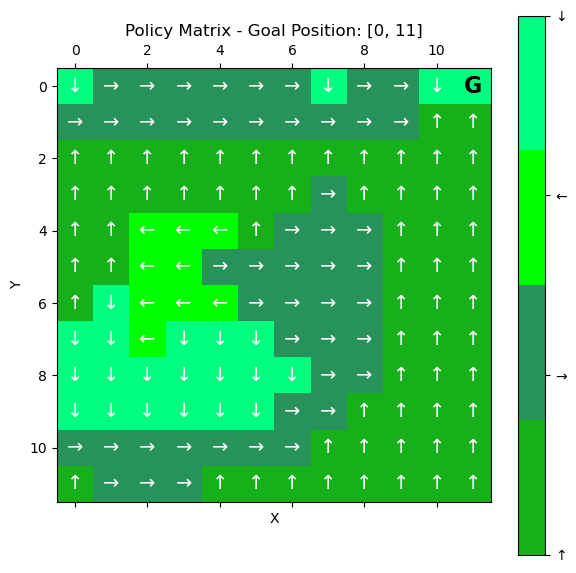

100%|██████████| 1000/1000 [00:02<00:00, 340.27it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 32.0


Episode  Total Reward  Number of Steps
0          1             0             1019
1          2             4              105
2          3             8              110
3          4            10               58
4          5             8               90
..       ...           ...              ...
995      996            10               39
996      997            10               28
997      998             9               32
998      999            10               21
999     1000            10               32

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 405.02it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 33.0


Episode  Total Reward  Number of Steps
0          1           -14               36
1          2           -16               42
2          3             2              100
3          4             8              315
4          5            -7              116
..       ...           ...              ...
995      996             6               30
996      997            10               29
997      998            10               24
998      999            10               13
999     1000            10               33

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 284.41it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0          1            -7              454
1          2           -14              105
2          3            10              169
3          4             7              676
4          5             9              457
..       ...           ...              ...
995      996             1               47
996      997             8               19
997      998             9               18
998      999            10               35
999     1000            10               18

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 349.53it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0          1             2              275
1          2             1              318
2          3             5              112
3          4            -4               14
4          5             5              674
..       ...           ...              ...
995      996            10               29
996      997             9               32
997      998            10               30
998      999            10               30
999     1000            10               26

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 330.80it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 60.0


Episode  Total Reward  Number of Steps
0          1            10              688
1          2           -13              610
2          3            -4               50
3          4            -6              123
4          5             0              118
..       ...           ...              ...
995      996            10               22
996      997            10               27
997      998            10               42
998      999            10               25
999     1000            10               60

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 302.48it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0          1             7              376
1          2            -2               37
2          3            -8              553
3          4             7               36
4          5             9              399
..       ...           ...              ...
995      996             9               37
996      997            10               26
997      998            10               62
998      999            10               40
999     1000             9               25

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 301.93it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0          1           -55             8057
1          2           -17               57
2          3            -4              135
3          4             2               41
4          5            10              275
..       ...           ...              ...
995      996            10               38
996      997            10               29
997      998            10               28
998      999            10               20
999     1000            10               25

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 322.87it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0          1           -15              193
1          2           -18               27
2          3             5              569
3          4             1              329
4          5           -13              117
..       ...           ...              ...
995      996            10               35
996      997            10               20
997      998            10               25
998      999            10               24
999     1000             9               21

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 405.18it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 54.0


Episode  Total Reward  Number of Steps
0          1           -12               25
1          2             3               14
2          3            -7               61
3          4            -2               90
4          5             9               47
..       ...           ...              ...
995      996            10               50
996      997            10               58
997      998            10               34
998      999             8               16
999     1000            10               54

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 340.95it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 11.0


Episode  Total Reward  Number of Steps
0          1             5              878
1          2             0              399
2          3             8              258
3          4            -8               92
4          5             9               87
..       ...           ...              ...
995      996             9               18
996      997            10               28
997      998             9               15
998      999            10               33
999     1000            10               11

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 309.69it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0          1           -14              859
1          2             1              137
2          3           -20              338
3          4           -13              358
4          5           -10              557
..       ...           ...              ...
995      996            10               26
996      997            -3               35
997      998             9               15
998      999            10               18
999     1000             9               14

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 364.43it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 0.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0          1            -6               16
1          2            -8             2077
2          3             9              461
3          4            10              393
4          5            -4               19
..       ...           ...              ...
995      996            10               44
996      997            10               25
997      998            10               37
998      999             9               19
999     1000             0               14

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 363.10it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0          1           -16              472
1          2             4              241
2          3            10              442
3          4           -11               99
4          5             8              125
..       ...           ...              ...
995      996            10               53
996      997            10               25
997      998            10               30
998      999             9               16
999     1000            10               17

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 348.80it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 6.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0          1           -10             1984
1          2            10              789
2          3            -4              138
3          4            -1              119
4          5             5              275
..       ...           ...              ...
995      996            10               34
996      997            10               42
997      998             9               15
998      999             8               15
999     1000             6               15

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 336.25it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 32.0


Episode  Total Reward  Number of Steps
0          1           -13              590
1          2            10              182
2          3            -3              161
3          4           -14               76
4          5             0               46
..       ...           ...              ...
995      996             8               28
996      997            10               56
997      998            10               19
998      999            10               41
999     1000            10               32

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 320.55it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 5.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0          1             1             2429
1          2           -23             2370
2          3           -25             1260
3          4             5               84
4          5           -18              135
..       ...           ...              ...
995      996             9               18
996      997             9               38
997      998            10               28
998      999             4               24
999     1000             5               29

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 336.47it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 37.0


Episode  Total Reward  Number of Steps
0          1           -50             4024
1          2            -7              547
2          3             2               82
3          4            10               77
4          5            10              116
..       ...           ...              ...
995      996            10               24
996      997            10               35
997      998             9               30
998      999            10               34
999     1000             9               37

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 346.14it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0          1           -24             1140
1          2            10              219
2          3             9              352
3          4            10              278
4          5             7              227
..       ...           ...              ...
995      996             9               11
996      997            10               23
997      998            10               27
998      999            10               35
999     1000            10               29

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 314.81it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 42.0


Episode  Total Reward  Number of Steps
0          1           -14             3901
1          2            -7               21
2          3             9              353
3          4             1              302
4          5            10              319
..       ...           ...              ...
995      996             9               37
996      997             9               14
997      998             9               33
998      999            10               34
999     1000             9               42

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 339.10it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0          1           -22             3387
1          2            -7              966
2          3            -4              564
3          4             9              228
4          5             9               82
..       ...           ...              ...
995      996             9               30
996      997             1               16
997      998            10               36
998      999            10               26
999     1000            10               16

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 300.39it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0          1            -4             2814
1          2           -13               18
2          3            -6              110
3          4             6              124
4          5             8               23
..       ...           ...              ...
995      996            10               16
996      997            10               34
997      998             9               29
998      999            10               36
999     1000            10               29

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 310.63it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0          1            10              493
1          2           -12              116
2          3           -10              150
3          4             1              265
4          5            -1              118
..       ...           ...              ...
995      996            10               14
996      997             8               22
997      998            10               33
998      999            10               51
999     1000             9               16

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 358.94it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0          1             9              139
1          2            -9               13
2          3            -4              620
3          4            -7               22
4          5             5               73
..       ...           ...              ...
995      996            10               37
996      997            10               15
997      998            10               29
998      999            10               60
999     1000            10               30

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 362.71it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0          1             5              910
1          2             9              483
2          3            -6              517
3          4             0              457
4          5             2              176
..       ...           ...              ...
995      996            10               38
996      997             9               27
997      998            10                8
998      999             8               14
999     1000            10               26

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 347.43it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 33.0


Episode  Total Reward  Number of Steps
0          1           -14              361
1          2            -6              826
2          3           -10              329
3          4           -26               93
4          5            -5               40
..       ...           ...              ...
995      996             9               52
996      997            10               44
997      998            10               37
998      999             9               34
999     1000             9               33

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 376.27it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0          1             4              158
1          2           -17               62
2          3             7              425
3          4             8              111
4          5            -6              342
..       ...           ...              ...
995      996             7               22
996      997            10               17
997      998            10               36
998      999             7               21
999     1000            10               19

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 383.15it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0          1           -12              319
1          2            10              464
2          3             9              151
3          4            -3               37
4          5            10              146
..       ...           ...              ...
995      996            10               15
996      997            10               16
997      998             9               25
998      999            10               37
999     1000             9               22

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 382.41it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 10.0


Episode  Total Reward  Number of Steps
0          1            -3               25
1          2             1              250
2          3             0              119
3          4            10              111
4          5             2               28
..       ...           ...              ...
995      996             9               42
996      997            10               55
997      998            10               23
998      999            10               20
999     1000             7               10

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 348.91it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0          1            -1              944
1          2            -1             2128
2          3            10              159
3          4             1              201
4          5             8              200
..       ...           ...              ...
995      996             9               23
996      997            10               25
997      998            10               47
998      999             9               29
999     1000            10               21

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 385.21it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0          1            -4               13
1          2            -1               10
2          3             1             2344
3          4             9               87
4          5             4              121
..       ...           ...              ...
995      996             9               15
996      997           -14               40
997      998             8               26
998      999            10               13
999     1000            10               17

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 328.12it/s]

-----------All episodes done-----------
Episode 1000: Total reward = -1.0, Number of steps = 34.0


Episode  Total Reward  Number of Steps
0          1            -9              704
1          2            10              144
2          3            -1               19
3          4             7              188
4          5             8              243
..       ...           ...              ...
995      996             6               33
996      997             9               53
997      998             7               15
998      999            10               16
999     1000            -1               34

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 298.86it/s]

-----------All episodes done-----------
Episode 1000: Total reward = -1.0, Number of steps = 11.0


Episode  Total Reward  Number of Steps
0          1           -63             5014
1          2             9              424
2          3             9              755
3          4            -3               19
4          5             3               41
..       ...           ...              ...
995      996            10               44
996      997            10               28
997      998            10               22
998      999            10               45
999     1000            -1               11

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 349.77it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0          1             0             1276
1          2            10             1343
2          3           -18               88
3          4             6              309
4          5             3              667
..       ...           ...              ...
995      996            10               20
996      997            -4               16
997      998            10               27
998      999            10               26
999     1000            10               23

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 346.62it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0          1           -34             3112
1          2            10              515
2          3            -1              194
3          4             7              133
4          5            10              114
..       ...           ...              ...
995      996            10               40
996      997            10               34
997      998            10               36
998      999            10               19
999     1000             9               23

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 319.28it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 35.0


Episode  Total Reward  Number of Steps
0          1             6              276
1          2           -25              996
2          3            -3               97
3          4           -19              155
4          5           -16               83
..       ...           ...              ...
995      996            10               22
996      997            10               26
997      998            10               36
998      999            10               50
999     1000            10               35

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 329.71it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0          1           -30             1162
1          2             9              170
2          3             2               63
3          4             6               68
4          5            10               84
..       ...           ...              ...
995      996            10               38
996      997            10               32
997      998            10               21
998      999            10               14
999     1000            10               22

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 334.50it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 39.0


Episode  Total Reward  Number of Steps
0          1             9              986
1          2           -10               97
2          3           -12               69
3          4            10              452
4          5           -22               23
..       ...           ...              ...
995      996             0               31
996      997            10               32
997      998            10               28
998      999             8               26
999     1000            10               39

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 325.73it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0          1             1              341
1          2            10              274
2          3            -1               61
3          4            -2               20
4          5            -8               70
..       ...           ...              ...
995      996            10               23
996      997             9               46
997      998            10               33
998      999            10               12
999     1000            10               25

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 360.88it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 33.0


Episode  Total Reward  Number of Steps
0          1           -31              204
1          2           -16              758
2          3            -2              212
3          4             9              273
4          5           -13               35
..       ...           ...              ...
995      996            10               41
996      997            10               30
997      998            -2               25
998      999             8               17
999     1000            10               33

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 378.78it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0          1            10              374
1          2             2               48
2          3             5              924
3          4           -25               42
4          5            -5               23
..       ...           ...              ...
995      996            10               27
996      997            10               30
997      998            10               39
998      999            10               18
999     1000            10               20

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 288.43it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 32.0


Episode  Total Reward  Number of Steps
0          1             2              272
1          2            10               54
2          3             3               93
3          4           -14               42
4          5           -11               29
..       ...           ...              ...
995      996            10               28
996      997            10               32
997      998            10               30
998      999            10               24
999     1000            10               32

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 353.09it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0          1            10              399
1          2           -13               77
2          3             9              181
3          4            -4               81
4          5            10               94
..       ...           ...              ...
995      996            10               27
996      997            10               23
997      998            10               24
998      999            10               34
999     1000            10               25

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 344.47it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 32.0


Episode  Total Reward  Number of Steps
0          1            -3             1410
1          2            -7              123
2          3             6              116
3          4            10              186
4          5            10               75
..       ...           ...              ...
995      996             9               25
996      997            10               42
997      998            10               37
998      999            10               36
999     1000            10               32

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 322.37it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 46.0


Episode  Total Reward  Number of Steps
0          1           -35              829
1          2           -15              353
2          3            -3               70
3          4            -6              246
4          5             1              353
..       ...           ...              ...
995      996             9               19
996      997            10               32
997      998            10               29
998      999             8               21
999     1000            10               46

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 352.48it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0          1            10              670
1          2             9              239
2          3             8              106
3          4            10               75
4          5            -5               15
..       ...           ...              ...
995      996            10               39
996      997            10               30
997      998            10               39
998      999            10               19
999     1000             8               17

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 360.36it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 37.0


Episode  Total Reward  Number of Steps
0          1             1             1338
1          2             8              113
2          3             3              804
3          4             5              143
4          5             1               60
..       ...           ...              ...
995      996            10               23
996      997            10               29
997      998            10               31
998      999            10               35
999     1000            10               37

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 343.76it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 41.0


Episode  Total Reward  Number of Steps
0          1             8              363
1          2           -17             3362
2          3            10              335
3          4             3              484
4          5             5              145
..       ...           ...              ...
995      996            10               31
996      997             3               31
997      998            10               23
998      999            10               13
999     1000            10               41

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 332.23it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0          1           -46             1489
1          2            -5             1099
2          3             0             1833
3          4             9              517
4          5             7              187
..       ...           ...              ...
995      996            10               26
996      997            10               30
997      998             9               25
998      999             7               23
999     1000            10               15

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 338.58it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0          1           -41               55
1          2           -12              786
2          3            -2               77
3          4             4              296
4          5            -4               11
..       ...           ...              ...
995      996            10               18
996      997            10               32
997      998            10               30
998      999             8               70
999     1000             9               25

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 274.42it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0          1           -28             3509
1          2            10              232
2          3            10              450
3          4            10              284
4          5             6              551
..       ...           ...              ...
995      996            10               26
996      997            10               27
997      998            10               15
998      999            10               14
999     1000            10               24

[1000 rows x 3 columns]

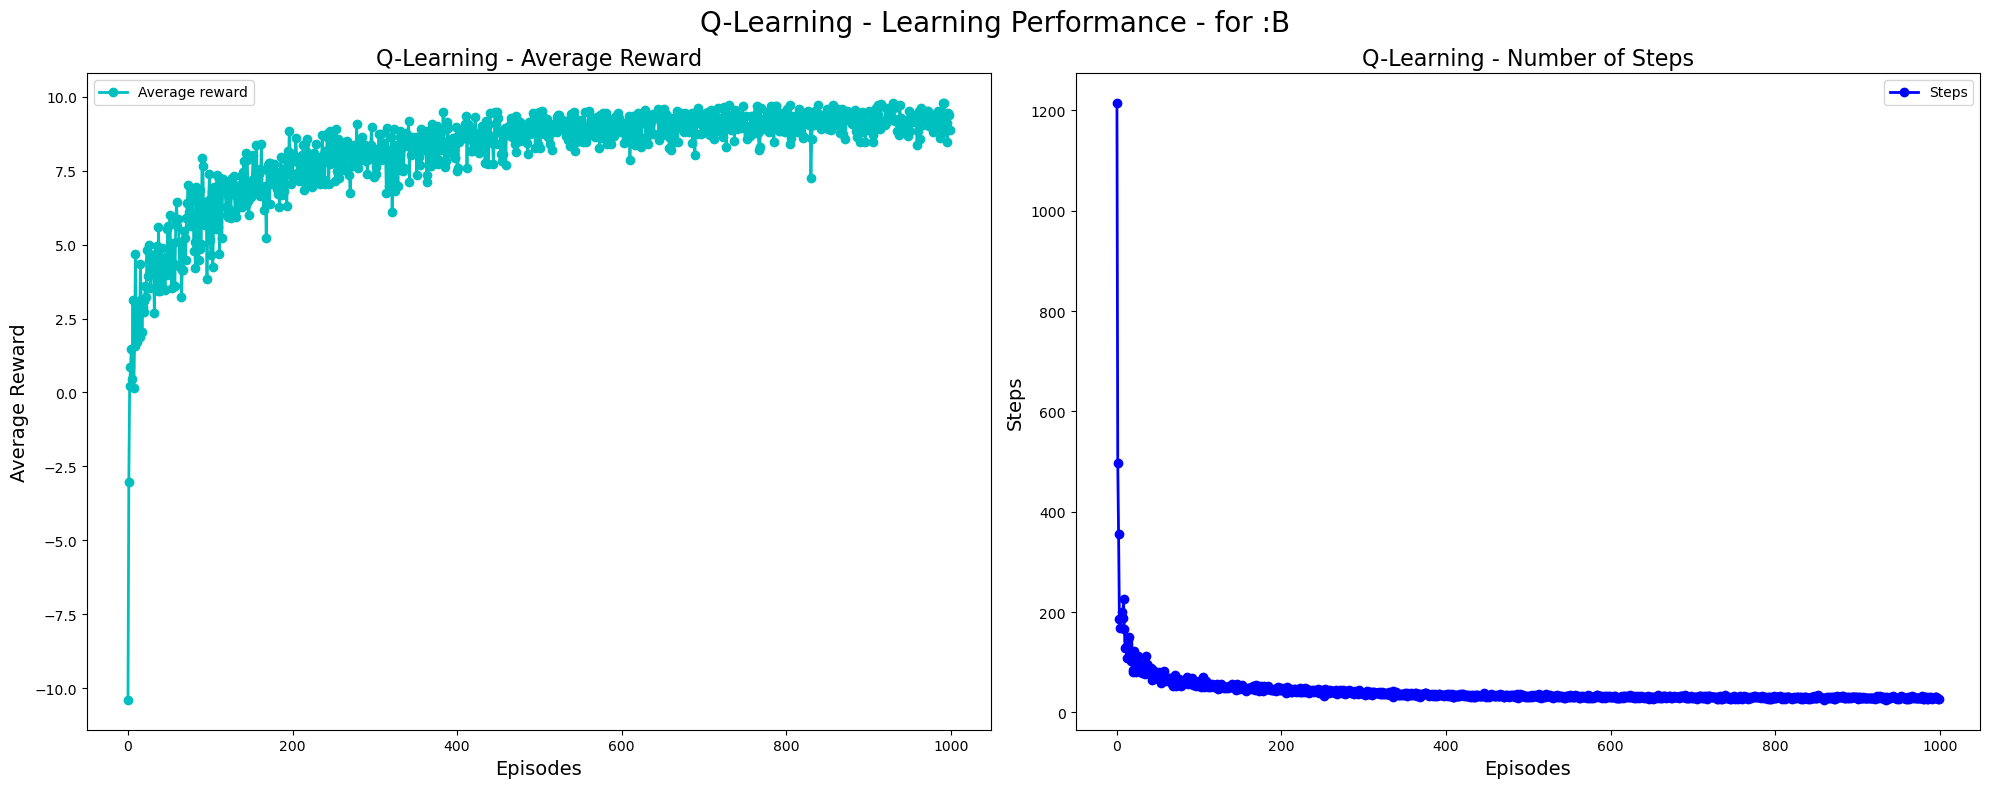

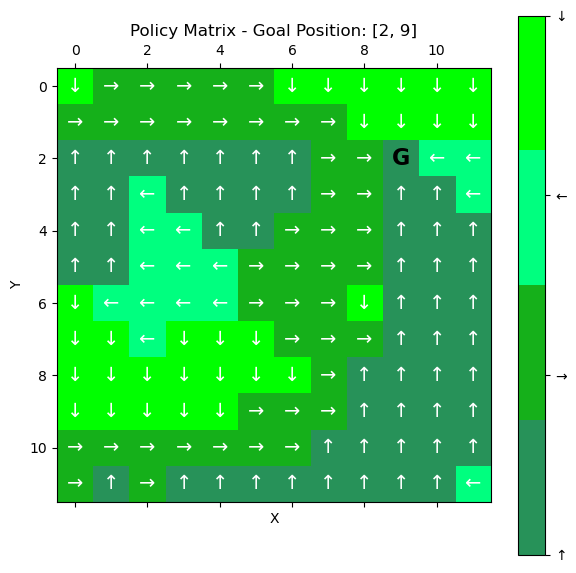

100%|██████████| 1000/1000 [00:02<00:00, 490.19it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0          1           -53              572
1          2            -5               59
2          3            -4              231
3          4           -45              861
4          5            -3              175
..       ...           ...              ...
995      996             8               22
996      997             9               15
997      998             9               18
998      999             9               23
999     1000             9               30

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 400.64it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 28.0


Episode  Total Reward  Number of Steps
0          1           -97             4015
1          2            -6              887
2          3            -4              539
3          4            -6              352
4          5            -9              150
..       ...           ...              ...
995      996             8               34
996      997             9               26
997      998             9               22
998      999             9               27
999     1000             9               28

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 387.45it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0          1           -40              875
1          2          -223             5132
2          3          -128             5951
3          4             6              267
4          5             4              177
..       ...           ...              ...
995      996             9               31
996      997             9               23
997      998             9               31
998      999             9               34
999     1000             9               17

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 443.85it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 28.0


Episode  Total Reward  Number of Steps
0          1          -373             7551
1          2           -12              923
2          3             4               88
3          4             2             1510
4          5             5              995
..       ...           ...              ...
995      996             9               20
996      997             6               39
997      998             9               23
998      999             9               30
999     1000             9               28

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 419.99it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0          1           -83             1320
1          2           -58             2470
2          3             5              667
3          4             9              349
4          5          -105             2220
..       ...           ...              ...
995      996             9               31
996      997             9               36
997      998             9               25
998      999             9               27
999     1000             7               30

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 404.04it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 4.0, Number of steps = 35.0


Episode  Total Reward  Number of Steps
0          1           -31              232
1          2          -262            10464
2          3           -42             2408
3          4           -77             4599
4          5             5              491
..       ...           ...              ...
995      996             7               34
996      997             9               29
997      998             9               17
998      999             9               19
999     1000             4               35

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 449.03it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 45.0


Episode  Total Reward  Number of Steps
0          1            -9              891
1          2             5              732
2          3           -28              671
3          4            -2              298
4          5            -4              448
..       ...           ...              ...
995      996             8               36
996      997             9               40
997      998             1               30
998      999             9               45
999     1000             9               45

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 531.56it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0          1           -59             1002
1          2           -23             1303
2          3             7              124
3          4           -11              948
4          5            -3              132
..       ...           ...              ...
995      996             9               20
996      997             6               21
997      998             9               16
998      999             6               21
999     1000             9               18

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 590.91it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 42.0


Episode  Total Reward  Number of Steps
0          1             1               43
1          2           -97             1004
2          3           -42              802
3          4            -5              483
4          5           -78             1027
..       ...           ...              ...
995      996             7               27
996      997             8               21
997      998             1               23
998      999             7               35
999     1000             9               42

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 403.83it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0          1           -62              667
1          2             9              218
2          3           -10              484
3          4             9              255
4          5           -19              816
..       ...           ...              ...
995      996             8               23
996      997             9               23
997      998             9               22
998      999             7               27
999     1000             9               21

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 396.83it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 27.0


Episode  Total Reward  Number of Steps
0          1          -185             1795
1          2           -77             3057
2          3           -53             2874
3          4             9              270
4          5             8              208
..       ...           ...              ...
995      996             8               26
996      997             9               25
997      998             6               37
998      999             9               22
999     1000             9               27

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 378.01it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0          1           -46             1177
1          2           -78             1222
2          3             0              249
3          4           -16              788
4          5             4              659
..       ...           ...              ...
995      996             9               26
996      997             9               26
997      998             9               23
998      999             4               40
999     1000             9               20

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 503.02it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0          1             7               68
1          2           -23              810
2          3            -8              767
3          4           -34              312
4          5             2              208
..       ...           ...              ...
995      996             9               25
996      997             9               20
997      998             7               26
998      999             9               17
999     1000             9               16

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 388.50it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0          1          -123             2171
1          2           -66             2966
2          3           -16              657
3          4             4              439
4          5             8              229
..       ...           ...              ...
995      996             9               18
996      997             9               25
997      998             9               22
998      999             8               39
999     1000             9               19

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 403.87it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 45.0


Episode  Total Reward  Number of Steps
0          1           -23              330
1          2           -26              340
2          3           -50              914
3          4           -35              431
4          5           -15              584
..       ...           ...              ...
995      996             9               31
996      997             9               23
997      998             9               29
998      999             5               31
999     1000             8               45

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 426.44it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0          1          -156             3782
1          2          -207             6624
2          3             6              632
3          4           -17             1988
4          5           -22              691
..       ...           ...              ...
995      996             9               21
996      997             9               23
997      998             9               19
998      999             7               19
999     1000             9               14

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 486.15it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 5.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0          1           -50             1681
1          2             6               84
2          3            -5              441
3          4           -85              751
4          5           -48             1095
..       ...           ...              ...
995      996             6               15
996      997             8               23
997      998             7               15
998      999             8               21
999     1000             5               25

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 591.72it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0          1           -44              751
1          2           -11              177
2          3           -43              731
3          4            -7              308
4          5          -122             1655
..       ...           ...              ...
995      996             7               20
996      997             7               22
997      998             4               17
998      999             4               26
999     1000             9               25

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 552.18it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0          1          -114             2866
1          2            -9              563
2          3           -16              638
3          4             9              230
4          5             6              650
..       ...           ...              ...
995      996             9               15
996      997             8               24
997      998             9               20
998      999             9               13
999     1000             9               15

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 416.15it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 33.0


Episode  Total Reward  Number of Steps
0          1           -73              255
1          2          -198             2572
2          3           -61             2705
3          4             6             1076
4          5            -4              552
..       ...           ...              ...
995      996             9               19
996      997             9               34
997      998             9               22
998      999             8               33
999     1000             9               33

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 486.86it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 31.0


Episode  Total Reward  Number of Steps
0          1            -8              228
1          2           -72              615
2          3           -37               92
3          4          -111             2540
4          5             8              124
..       ...           ...              ...
995      996             9               34
996      997             9               24
997      998             9               17
998      999             9               24
999     1000             9               31

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 448.02it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 31.0


Episode  Total Reward  Number of Steps
0          1           -24              635
1          2          -128             4325
2          3             9              137
3          4             5              332
4          5           -12              308
..       ...           ...              ...
995      996             8               23
996      997             9               27
997      998             9               33
998      999             9               31
999     1000             7               31

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 549.75it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0          1           -98              196
1          2            -8              256
2          3             3              119
3          4            -4              391
4          5             8               80
..       ...           ...              ...
995      996             3               29
996      997             9               17
997      998             8               16
998      999             8               15
999     1000             8               24

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 502.01it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0          1           -30              319
1          2            -8              238
2          3           -10              285
3          4             7              144
4          5             4              612
..       ...           ...              ...
995      996             9               16
996      997             9               25
997      998             7               22
998      999             7               31
999     1000             9               21

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 413.39it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 36.0


Episode  Total Reward  Number of Steps
0          1          -183             5690
1          2             0              400
2          3           -48             2323
3          4           -43              411
4          5            -9              972
..       ...           ...              ...
995      996             8               26
996      997             9               30
997      998             9               20
998      999             9               27
999     1000             9               36

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 376.22it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 6.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0          1           -73              131
1          2          -110             3359
2          3           -32             3449
3          4          -193             7466
4          5           -35              616
..       ...           ...              ...
995      996             9               24
996      997             8               22
997      998             9               20
998      999             6               28
999     1000             6               22

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 417.79it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 31.0


Episode  Total Reward  Number of Steps
0          1           -24              103
1          2           -94             2917
2          3            -9              429
3          4             3              203
4          5             5              292
..       ...           ...              ...
995      996             9               26
996      997             9               26
997      998             9               24
998      999             8               26
999     1000             9               31

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 405.67it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0          1           -23              177
1          2          -568            16080
2          3            -9             1202
3          4             6              112
4          5             9               38
..       ...           ...              ...
995      996             9               20
996      997             9               20
997      998             9               13
998      999             9               26
999     1000             9               14

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 469.50it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0          1           -33              186
1          2            -5               69
2          3           -36             1313
3          4           -23              710
4          5           -28              828
..       ...           ...              ...
995      996             9               20
996      997             8               29
997      998             9               17
998      999             9               33
999     1000             9               20

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 491.18it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0          1          -195             3375
1          2             9              209
2          3             7              193
3          4             9              231
4          5             5              216
..       ...           ...              ...
995      996             9               35
996      997             9               30
997      998             5               34
998      999             9               15
999     1000             9               25

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 451.47it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0          1           -86             2886
1          2           -23              835
2          3            -9             1049
3          4            -4             1183
4          5            -2              703
..       ...           ...              ...
995      996             7               21
996      997             8               26
997      998             8               19
998      999             7               29
999     1000             8               25

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 509.37it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0          1           -13               80
1          2           -50             1563
2          3             8              104
3          4           -12              255
4          5             5              183
..       ...           ...              ...
995      996             8               26
996      997             9               25
997      998             9               19
998      999             9               21
999     1000             9               19

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 436.49it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0          1          -369             6837
1          2           -20             1958
2          3           -24              904
3          4           -10              180
4          5           -26             1440
..       ...           ...              ...
995      996             8               24
996      997             5               36
997      998             4               23
998      999             9               21
999     1000             8               21

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 394.93it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0          1          -210             2435
1          2           -16              880
2          3           -58             2743
3          4           -72             2847
4          5           -11             1441
..       ...           ...              ...
995      996             6               19
996      997             9               19
997      998             6               36
998      999             9               25
999     1000             9               20

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 480.51it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0          1           -54             1692
1          2           -14              107
2          3             4              455
3          4           -90             1322
4          5            -8              289
..       ...           ...              ...
995      996             9               19
996      997             9               18
997      998             9               15
998      999             2               27
999     1000             8               22

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 347.72it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0          1           -40              220
1          2           -11              441
2          3           -23             1210
3          4           -32             1033
4          5             2               18
..       ...           ...              ...
995      996             6               15
996      997             8               24
997      998             9               19
998      999             8               17
999     1000             9               16

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 385.06it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 36.0


Episode  Total Reward  Number of Steps
0          1          -214             3638
1          2           -61             3662
2          3          -128             4472
3          4          -147             2677
4          5           -17              737
..       ...           ...              ...
995      996             8               26
996      997             9               23
997      998             9               13
998      999             9               34
999     1000             8               36

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 582.42it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0          1           -46               48
1          2             3               65
2          3            -9               63
3          4          -205             3981
4          5           -12             2257
..       ...           ...              ...
995      996             8               11
996      997             1               26
997      998             8               17
998      999             8               15
999     1000             8               20

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 444.74it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 42.0


Episode  Total Reward  Number of Steps
0          1             1              249
1          2           -22             1053
2          3          -123             1259
3          4             7              260
4          5             9               86
..       ...           ...              ...
995      996             9               22
996      997             9               25
997      998             9               24
998      999             8               36
999     1000             8               42

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 501.00it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0          1          -103             1220
1          2             0              322
2          3             6              161
3          4            -1               70
4          5             8              298
..       ...           ...              ...
995      996             9               30
996      997             8               30
997      998             9               31
998      999             6               24
999     1000             9               19

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 289.31it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0          1          -139             3834
1          2          -169             5577
2          3          -143            11499
3          4            -6             1168
4          5           -66             5656
..       ...           ...              ...
995      996             9               28
996      997             9               22
997      998             8               23
998      999             9               17
999     1000             7               19

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 514.14it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 35.0


Episode  Total Reward  Number of Steps
0          1          -141             1522
1          2           -18              463
2          3           -45             1227
3          4             0              195
4          5            -6              421
..       ...           ...              ...
995      996             9               21
996      997             6               30
997      998             9               22
998      999             9               24
999     1000             8               35

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 504.26it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 28.0


Episode  Total Reward  Number of Steps
0          1           -70              798
1          2             3              108
2          3          -103              862
3          4          -215             5090
4          5            -2              617
..       ...           ...              ...
995      996             9               19
996      997             9               18
997      998             9               17
998      999             7               28
999     1000             9               28

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 304.99it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0          1           -87             2865
1          2          -355            17476
2          3           -75             2589
3          4          -125             9631
4          5             8              587
..       ...           ...              ...
995      996             9               20
996      997             9               31
997      998             9               18
998      999             9               30
999     1000             9               21

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 519.48it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0          1           -61             2498
1          2             4              130
2          3             3               97
3          4             7               99
4          5             1               95
..       ...           ...              ...
995      996             9               14
996      997             6               29
997      998             7               21
998      999             9               21
999     1000             9               29

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 384.32it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 32.0


Episode  Total Reward  Number of Steps
0          1          -123             2539
1          2           -16              571
2          3          -179             6834
3          4             5             1034
4          5             8              164
..       ...           ...              ...
995      996             9               23
996      997             9               20
997      998             9               26
998      999             9               26
999     1000             9               32

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 361.14it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0          1          -396             7653
1          2           -77             5690
2          3             6              267
3          4             7              152
4          5             5              210
..       ...           ...              ...
995      996             9               27
996      997             8               31
997      998             8               30
998      999             9               26
999     1000             9               21

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 472.14it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0          1           -36              392
1          2             5              131
2          3          -209             1014
3          4             3              130
4          5             5              216
..       ...           ...              ...
995      996             9               20
996      997             7               25
997      998             9               17
998      999             9               17
999     1000             9               14

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 447.82it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0          1           -65             1445
1          2            -2              243
2          3             8              196
3          4             4              235
4          5             0              337
..       ...           ...              ...
995      996             7               19
996      997             9               14
997      998             9               15
998      999             9               20
999     1000             9               22

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 488.99it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0          1           -16              167
1          2           -97             1135
2          3          -136             4663
3          4            -2              243
4          5            -2             1037
..       ...           ...              ...
995      996             9               17
996      997             7               21
997      998             9               21
998      999             9               19
999     1000             9               15

[1000 rows x 3 columns]

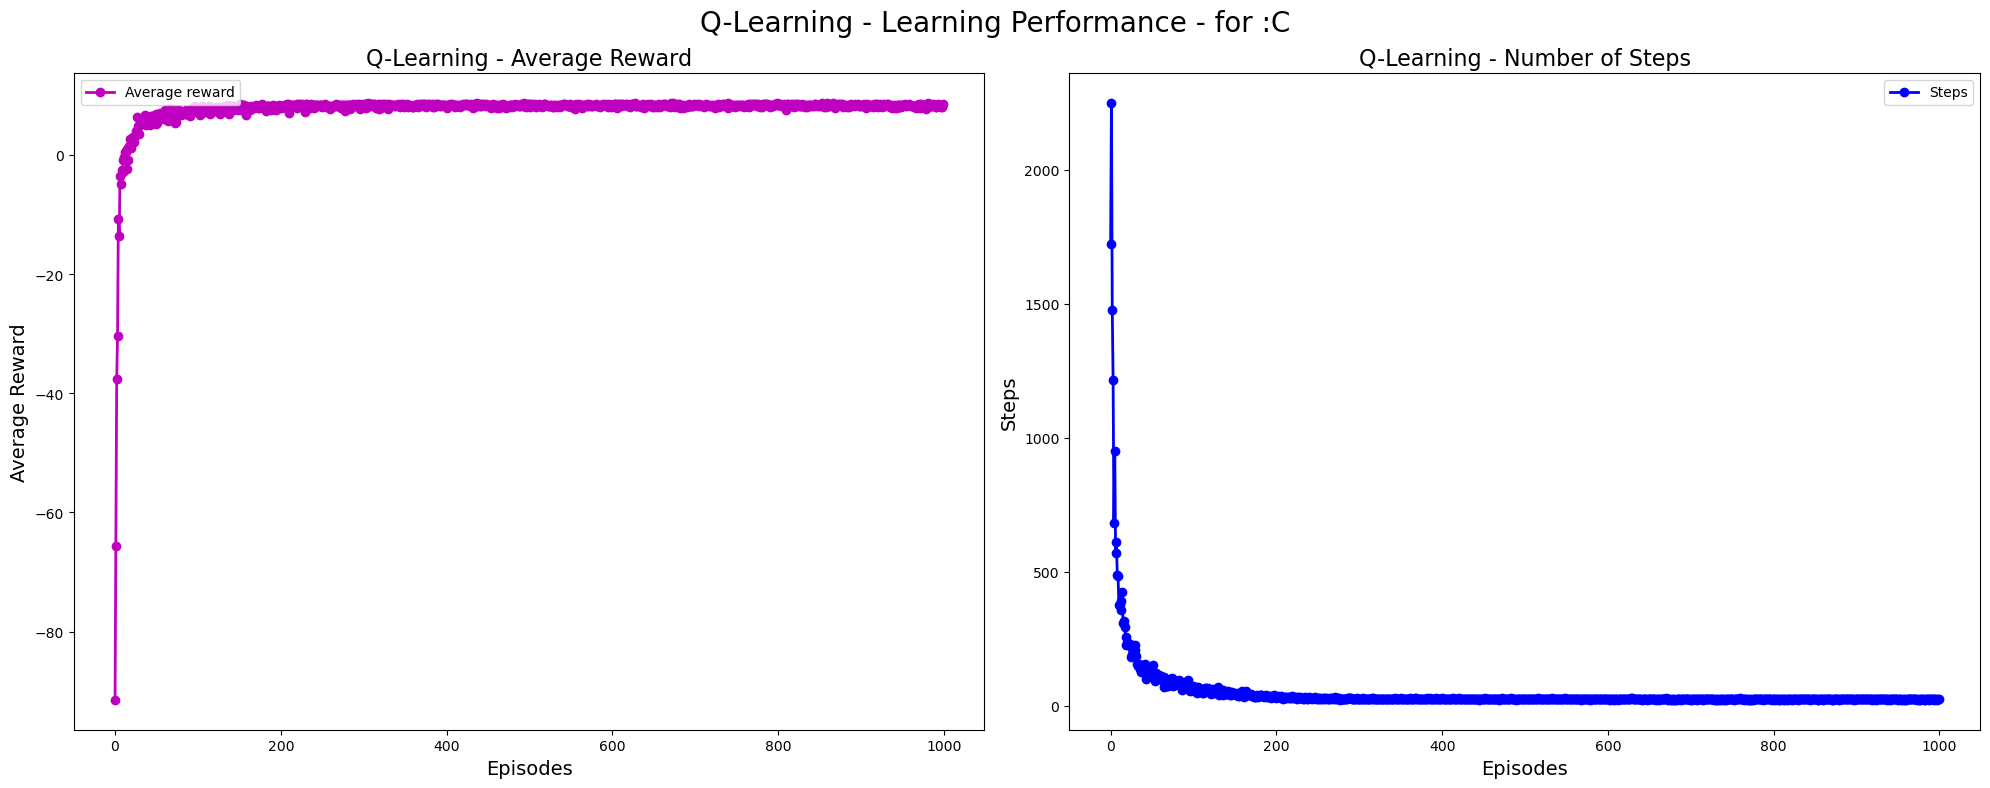

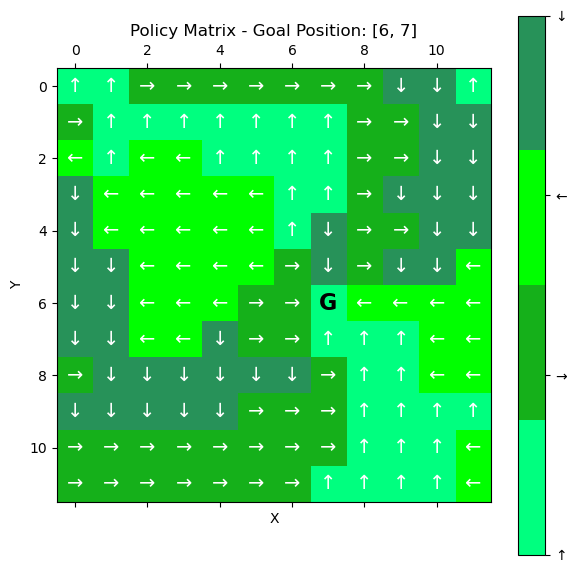

In [17]:
for goal_QLearning in ['A','B','C']:
    # Get the goal position from the goal_positions dictionary
    goal_pos_QLearning = goal_positions.get(goal_QLearning, [0, 11])
    
    # Run 50 independent run
    episode_data_list_QLearning = []
    
    for _ in range(independent_run):
        avg_reward, steps, Q = algo_object_QLearning.episode_run(gamma, alpha, epsilon, episodes, PuddleWorld(), goal_QLearning)
        episode_data_list_QLearning.append((avg_reward, steps, Q))        
    
    # Calculate the average rewards and average steps over the 50 runs
    avg_rewards_QLearning, avg_steps_QLearning = np.zeros([episodes]),np.zeros([episodes])
    
    for i in range(episodes):
        for j in range(len(episode_data_list_QLearning)):
            avg_rewards_QLearning[i] += episode_data_list_QLearning[j][0][i]/len(episode_data_list_QLearning)
            avg_steps_QLearning[i] += episode_data_list_QLearning[j][1][i]/len(episode_data_list_QLearning)
    
    # Calculate the policy matrix based on the most common action in each state
    policy_matrix_QLearning = np.zeros((12, 12), dtype=int)
    action_counts_QLearning = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for i in range(12):
        for j in range(12):
            for k in range(len(episode_data_list_QLearning)):
                action_counts_QLearning[np.argmax(episode_data_list_QLearning[k][2], axis=QLearning_axis)[i, j]] += 1
            max_action_QLearning = max(action_counts_QLearning, key=action_counts_QLearning.get)
            action_counts_QLearning = {0: 0, 1: 0, 2: 0, 3: 0}
            policy_matrix_QLearning[i, j] = max_action_QLearning        
    
    # Plot the reward and steps per episode for the current goal using Q Learning
    plot_reward_steps(avg_rewards_QLearning, avg_steps_QLearning, episodes, 'Q-Learning', goal_QLearning)
    
    # Plot the policy matrix for the current goal using Q Learning
    plot_policy(goal_pos_QLearning, policy_matrix_QLearning)

### SARSA execution for each goal

100%|██████████| 1000/1000 [00:03<00:00, 331.78it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0          1  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   
1          2  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   
2          3  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   
3          4  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   
4          5  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   
..       ...                                                ...   
995      996  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   
996      997  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   
997      998  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   
998      999  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   
999     1000  [-13.0, -33.0, 8.0, -12.0, 7.0, 9.0, 10.0, 8.0...   

     Number of Steps  
0             3510.0  
1             2501.0  
2             1256.0  
3               35.0  
4               92.0  
..               ...  
995             30.0  
996             29.0  
997             24.0  
998             20.0  
999             12.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 353.39it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 34.0


Episode                                         Avg Reward  \
0          1  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   
1          2  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   
2          3  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   
3          4  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   
4          5  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   
..       ...                                                ...   
995      996  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   
996      997  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   
997      998  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   
998      999  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   
999     1000  [-10.0, -3.0, 7.0, -44.0, 10.0, -4.0, -10.0, -...   

     Number of Steps  
0              604.0  
1               66.0  
2              144.0  
3               59.0  
4              158.0  
..               ...  
995             22.0  
996             21.0  
997             37.0  
998             27.0  
999             34.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 315.36it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   
1          2  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   
2          3  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   
3          4  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   
4          5  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   
..       ...                                                ...   
995      996  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   
996      997  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   
997      998  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   
998      999  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   
999     1000  [4.0, -5.0, -7.0, 10.0, 10.0, 10.0, 9.0, 6.0, ...   

     Number of Steps  
0               47.0  
1             2075.0  
2               57.0  
3              803.0  
4              282.0  
..               ...  
995             35.0  
996             32.0  
997             11.0  
998             42.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 364.45it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0          1  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   
1          2  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   
2          3  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   
3          4  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   
4          5  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   
..       ...                                                ...   
995      996  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   
996      997  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   
997      998  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   
998      999  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   
999     1000  [-12.0, -52.0, -1.0, -6.0, 10.0, -8.0, -2.0, 0...   

     Number of Steps  
0             1003.0  
1              447.0  
2               23.0  
3              102.0  
4              101.0  
..               ...  
995             35.0  
996             28.0  
997             28.0  
998             36.0  
999             16.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 344.59it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0          1  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   
1          2  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   
2          3  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   
3          4  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   
4          5  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   
..       ...                                                ...   
995      996  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   
996      997  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   
997      998  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   
998      999  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   
999     1000  [-20.0, 8.0, 10.0, 9.0, -8.0, 10.0, -8.0, 3.0,...   

     Number of Steps  
0             2061.0  
1              157.0  
2               96.0  
3              172.0  
4               50.0  
..               ...  
995             13.0  
996             32.0  
997             32.0  
998             15.0  
999             18.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 333.50it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0          1  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   
1          2  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   
2          3  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   
3          4  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   
4          5  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   
..       ...                                                ...   
995      996  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   
996      997  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   
997      998  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   
998      999  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   
999     1000  [-23.0, -16.0, 5.0, -3.0, -16.0, 5.0, 0.0, 9.0...   

     Number of Steps  
0             1820.0  
1               69.0  
2              670.0  
3              216.0  
4              642.0  
..               ...  
995             51.0  
996             16.0  
997             17.0  
998             24.0  
999             26.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 315.20it/s]

-----------All episodes done-----------
Episode 1000: Total reward = -3.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   
1          2  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   
2          3  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   
3          4  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   
4          5  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   
..       ...                                                ...   
995      996  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   
996      997  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   
997      998  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   
998      999  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   
999     1000  [-20.0, -9.0, 4.0, 7.0, 10.0, 4.0, 10.0, 8.0, ...   

     Number of Steps  
0             1610.0  
1             1911.0  
2               88.0  
3               32.0  
4               80.0  
..               ...  
995             40.0  
996             33.0  
997             41.0  
998             25.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 379.94it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0          1  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   
1          2  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   
2          3  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   
3          4  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   
4          5  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   
..       ...                                                ...   
995      996  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   
996      997  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   
997      998  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   
998      999  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   
999     1000  [3.0, 0.0, -38.0, 8.0, 1.0, 10.0, 10.0, 10.0, ...   

     Number of Steps  
0              256.0  
1              388.0  
2              176.0  
3              193.0  
4              106.0  
..               ...  
995             17.0  
996             26.0  
997             27.0  
998             37.0  
999             16.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 365.90it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 37.0


Episode                                         Avg Reward  \
0          1  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   
1          2  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   
2          3  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   
3          4  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   
4          5  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   
..       ...                                                ...   
995      996  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   
996      997  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   
997      998  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   
998      999  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   
999     1000  [2.0, 6.0, -14.0, 8.0, 3.0, 10.0, 10.0, -11.0,...   

     Number of Steps  
0               35.0  
1              497.0  
2             3384.0  
3              139.0  
4              522.0  
..               ...  
995             30.0  
996             24.0  
997             25.0  
998             24.0  
999             37.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 311.66it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 34.0


Episode                                         Avg Reward  \
0          1  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   
1          2  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   
2          3  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   
3          4  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   
4          5  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   
..       ...                                                ...   
995      996  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   
996      997  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   
997      998  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   
998      999  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   
999     1000  [-98.0, -12.0, -14.0, 6.0, 10.0, 2.0, -21.0, 1...   

     Number of Steps  
0              995.0  
1             5644.0  
2               97.0  
3              720.0  
4              142.0  
..               ...  
995             20.0  
996             23.0  
997             31.0  
998             27.0  
999             34.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 335.01it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode                                         Avg Reward  \
0          1  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   
1          2  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   
2          3  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   
3          4  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   
4          5  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   
..       ...                                                ...   
995      996  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   
996      997  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   
997      998  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   
998      999  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   
999     1000  [0.0, 1.0, -7.0, 5.0, 1.0, 7.0, -7.0, 3.0, 6.0...   

     Number of Steps  
0             1523.0  
1              991.0  
2             1157.0  
3              232.0  
4               84.0  
..               ...  
995             27.0  
996             33.0  
997             35.0  
998             30.0  
999             29.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 335.46it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 28.0


Episode                                         Avg Reward  \
0          1  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   
1          2  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   
2          3  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   
3          4  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   
4          5  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   
..       ...                                                ...   
995      996  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   
996      997  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   
997      998  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   
998      999  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   
999     1000  [-15.0, -2.0, 2.0, 6.0, 10.0, 1.0, -16.0, 1.0,...   

     Number of Steps  
0             2417.0  
1              161.0  
2              546.0  
3              232.0  
4              581.0  
..               ...  
995             16.0  
996             16.0  
997             21.0  
998             22.0  
999             28.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 383.73it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 30.0


Episode                                         Avg Reward  \
0          1  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   
1          2  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   
2          3  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   
3          4  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   
4          5  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   
..       ...                                                ...   
995      996  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   
996      997  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   
997      998  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   
998      999  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   
999     1000  [-16.0, 10.0, 10.0, -12.0, 6.0, 10.0, -11.0, 7...   

     Number of Steps  
0              953.0  
1               79.0  
2              163.0  
3               50.0  
4              165.0  
..               ...  
995             18.0  
996             14.0  
997             41.0  
998             20.0  
999             30.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 349.89it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 39.0


Episode                                         Avg Reward  \
0          1  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   
1          2  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   
2          3  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   
3          4  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   
4          5  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   
..       ...                                                ...   
995      996  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   
996      997  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   
997      998  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   
998      999  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   
999     1000  [-1.0, -2.0, 10.0, -6.0, 9.0, 10.0, 0.0, 8.0, ...   

     Number of Steps  
0               32.0  
1              383.0  
2              162.0  
3              153.0  
4               79.0  
..               ...  
995             32.0  
996             39.0  
997             35.0  
998             38.0  
999             39.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 380.80it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 25.0


Episode                                         Avg Reward  \
0          1  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   
1          2  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   
2          3  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   
3          4  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   
4          5  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   
..       ...                                                ...   
995      996  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   
996      997  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   
997      998  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   
998      999  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   
999     1000  [-44.0, 4.0, 2.0, 8.0, 10.0, -4.0, -5.0, 2.0, ...   

     Number of Steps  
0              462.0  
1               94.0  
2              152.0  
3              476.0  
4              344.0  
..               ...  
995             23.0  
996             34.0  
997             18.0  
998             26.0  
999             25.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 357.65it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0          1  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   
1          2  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   
2          3  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   
3          4  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   
4          5  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   
..       ...                                                ...   
995      996  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   
996      997  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   
997      998  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   
998      999  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   
999     1000  [-5.0, 5.0, 10.0, -2.0, -3.0, 4.0, 0.0, 10.0, ...   

     Number of Steps  
0             1869.0  
1               87.0  
2              713.0  
3               86.0  
4               88.0  
..               ...  
995             36.0  
996             18.0  
997             24.0  
998             17.0  
999             23.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 356.50it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0          1  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   
1          2  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   
2          3  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   
3          4  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   
4          5  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   
..       ...                                                ...   
995      996  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   
996      997  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   
997      998  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   
998      999  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   
999     1000  [-86.0, -10.0, -23.0, 8.0, 7.0, 9.0, -8.0, 10....   

     Number of Steps  
0             2390.0  
1              831.0  
2             1825.0  
3              365.0  
4              361.0  
..               ...  
995             28.0  
996             15.0  
997             23.0  
998             45.0  
999             23.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 406.01it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0          1  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   
1          2  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   
2          3  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   
3          4  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   
4          5  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   
..       ...                                                ...   
995      996  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   
996      997  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   
997      998  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   
998      999  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   
999     1000  [-1.0, -17.0, -22.0, -1.0, -1.0, -18.0, 7.0, -...   

     Number of Steps  
0              445.0  
1               52.0  
2             1040.0  
3               97.0  
4              279.0  
..               ...  
995             15.0  
996             37.0  
997             15.0  
998             35.0  
999             13.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 332.55it/s]

-----------All episodes done-----------
Episode 1000: Total reward = -3.0, Number of steps = 31.0


Episode                                         Avg Reward  \
0          1  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   
1          2  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   
2          3  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   
3          4  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   
4          5  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   
..       ...                                                ...   
995      996  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   
996      997  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   
997      998  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   
998      999  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   
999     1000  [-42.0, 4.0, -8.0, -7.0, -2.0, -16.0, 8.0, 4.0...   

     Number of Steps  
0             3036.0  
1              526.0  
2              322.0  
3             1321.0  
4              171.0  
..               ...  
995             26.0  
996             30.0  
997             19.0  
998             21.0  
999             31.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 361.27it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0          1  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   
1          2  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   
2          3  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   
3          4  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   
4          5  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   
..       ...                                                ...   
995      996  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   
996      997  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   
997      998  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   
998      999  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   
999     1000  [-9.0, -22.0, 6.0, 9.0, -9.0, 9.0, 9.0, 9.0, 1...   

     Number of Steps  
0             3557.0  
1              215.0  
2               39.0  
3              451.0  
4              331.0  
..               ...  
995             37.0  
996             19.0  
997             28.0  
998             14.0  
999             18.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 344.71it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode                                         Avg Reward  \
0          1  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   
1          2  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   
2          3  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   
3          4  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   
4          5  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   
..       ...                                                ...   
995      996  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   
996      997  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   
997      998  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   
998      999  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   
999     1000  [-7.0, 2.0, -3.0, 9.0, 10.0, -12.0, -2.0, 10.0...   

     Number of Steps  
0             1689.0  
1              312.0  
2               38.0  
3              243.0  
4              239.0  
..               ...  
995             31.0  
996             31.0  
997             26.0  
998             27.0  
999             29.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 362.32it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 28.0


Episode                                         Avg Reward  \
0          1  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   
1          2  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   
2          3  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   
3          4  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   
4          5  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   
..       ...                                                ...   
995      996  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   
996      997  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   
997      998  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   
998      999  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   
999     1000  [-5.0, -1.0, 8.0, 10.0, 3.0, 9.0, -9.0, 10.0, ...   

     Number of Steps  
0              373.0  
1             1205.0  
2              301.0  
3               70.0  
4              293.0  
..               ...  
995             28.0  
996             14.0  
997             34.0  
998             35.0  
999             28.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 336.81it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   
1          2  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   
2          3  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   
3          4  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   
4          5  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   
..       ...                                                ...   
995      996  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   
996      997  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   
997      998  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   
998      999  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   
999     1000  [1.0, -11.0, 3.0, -15.0, 10.0, 10.0, 1.0, 3.0,...   

     Number of Steps  
0             1110.0  
1              159.0  
2               25.0  
3               26.0  
4               98.0  
..               ...  
995             29.0  
996             25.0  
997             26.0  
998             36.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 321.85it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 32.0


Episode                                         Avg Reward  \
0          1  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   
1          2  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   
2          3  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   
3          4  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   
4          5  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   
..       ...                                                ...   
995      996  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   
996      997  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   
997      998  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   
998      999  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   
999     1000  [-24.0, -10.0, -2.0, -42.0, 6.0, 10.0, -6.0, 1...   

     Number of Steps  
0             1021.0  
1              425.0  
2              300.0  
3               72.0  
4              196.0  
..               ...  
995             27.0  
996             39.0  
997             45.0  
998             34.0  
999             32.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 379.80it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 11.0


Episode                                         Avg Reward  \
0          1  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   
1          2  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   
2          3  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   
3          4  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   
4          5  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   
..       ...                                                ...   
995      996  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   
996      997  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   
997      998  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   
998      999  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   
999     1000  [9.0, -38.0, -12.0, -10.0, -18.0, 10.0, 3.0, 8...   

     Number of Steps  
0              245.0  
1              328.0  
2               39.0  
3               61.0  
4               63.0  
..               ...  
995             16.0  
996             39.0  
997             12.0  
998             44.0  
999             11.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 348.19it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0          1  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   
1          2  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   
2          3  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   
3          4  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   
4          5  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   
..       ...                                                ...   
995      996  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   
996      997  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   
997      998  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   
998      999  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   
999     1000  [-14.0, 7.0, -16.0, -2.0, -8.0, 7.0, 9.0, -25....   

     Number of Steps  
0              159.0  
1              236.0  
2              306.0  
3               13.0  
4               27.0  
..               ...  
995             28.0  
996             21.0  
997             15.0  
998             19.0  
999             16.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 343.29it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 22.0


Episode                                         Avg Reward  \
0          1  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   
1          2  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   
2          3  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   
3          4  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   
4          5  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   
..       ...                                                ...   
995      996  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   
996      997  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   
997      998  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   
998      999  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   
999     1000  [-12.0, -15.0, 10.0, 8.0, 10.0, 10.0, 1.0, -18...   

     Number of Steps  
0              273.0  
1              235.0  
2              123.0  
3             1509.0  
4               61.0  
..               ...  
995             12.0  
996             23.0  
997             34.0  
998             42.0  
999             22.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 360.55it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   
1          2  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   
2          3  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   
3          4  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   
4          5  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   
..       ...                                                ...   
995      996  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   
996      997  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   
997      998  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   
998      999  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   
999     1000  [-5.0, 6.0, 10.0, -2.0, 10.0, -9.0, 10.0, 10.0...   

     Number of Steps  
0             2638.0  
1               89.0  
2              226.0  
3               26.0  
4              192.0  
..               ...  
995             35.0  
996             17.0  
997             18.0  
998             23.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 304.78it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0          1  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   
1          2  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   
2          3  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   
3          4  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   
4          5  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   
..       ...                                                ...   
995      996  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   
996      997  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   
997      998  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   
998      999  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   
999     1000  [5.0, -18.0, 10.0, -7.0, 4.0, 10.0, 5.0, 7.0, ...   

     Number of Steps  
0              541.0  
1              110.0  
2               93.0  
3              159.0  
4              117.0  
..               ...  
995             36.0  
996             35.0  
997             35.0  
998             31.0  
999             16.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 326.37it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0          1  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   
1          2  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   
2          3  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   
3          4  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   
4          5  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   
..       ...                                                ...   
995      996  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   
996      997  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   
997      998  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   
998      999  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   
999     1000  [-4.0, -4.0, -30.0, -3.0, -2.0, -3.0, 8.0, -15...   

     Number of Steps  
0               67.0  
1               66.0  
2              130.0  
3               33.0  
4               27.0  
..               ...  
995             14.0  
996             17.0  
997             40.0  
998             17.0  
999             20.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 350.63it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0          1  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   
1          2  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   
2          3  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   
3          4  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   
4          5  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   
..       ...                                                ...   
995      996  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   
996      997  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   
997      998  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   
998      999  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   
999     1000  [-13.0, 6.0, 4.0, -26.0, -7.0, 10.0, -7.0, -2....   

     Number of Steps  
0              570.0  
1             1212.0  
2               47.0  
3              548.0  
4              185.0  
..               ...  
995             22.0  
996             34.0  
997             28.0  
998             41.0  
999             23.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 337.27it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 36.0


Episode                                         Avg Reward  \
0          1  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   
1          2  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   
2          3  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   
3          4  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   
4          5  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   
..       ...                                                ...   
995      996  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   
996      997  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   
997      998  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   
998      999  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   
999     1000  [0.0, 7.0, -2.0, 8.0, 0.0, 9.0, -5.0, 10.0, -3...   

     Number of Steps  
0             1405.0  
1              191.0  
2               52.0  
3              174.0  
4               71.0  
..               ...  
995             18.0  
996             27.0  
997             33.0  
998             43.0  
999             36.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 342.58it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0          1  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   
1          2  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   
2          3  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   
3          4  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   
4          5  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   
..       ...                                                ...   
995      996  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   
996      997  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   
997      998  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   
998      999  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   
999     1000  [-24.0, 5.0, 7.0, 1.0, 9.0, 5.0, -3.0, 0.0, -1...   

     Number of Steps  
0             3852.0  
1              214.0  
2              132.0  
3               44.0  
4              127.0  
..               ...  
995             37.0  
996             28.0  
997             37.0  
998             32.0  
999             21.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 331.89it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 36.0


Episode                                         Avg Reward  \
0          1  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   
1          2  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   
2          3  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   
3          4  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   
4          5  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   
..       ...                                                ...   
995      996  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   
996      997  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   
997      998  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   
998      999  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   
999     1000  [3.0, -16.0, -3.0, -49.0, 7.0, 8.0, -9.0, 10.0...   

     Number of Steps  
0             3279.0  
1              688.0  
2               98.0  
3             2298.0  
4              368.0  
..               ...  
995             15.0  
996             23.0  
997             37.0  
998             17.0  
999             36.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 413.30it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0          1  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   
1          2  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   
2          3  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   
3          4  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   
4          5  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   
..       ...                                                ...   
995      996  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   
996      997  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   
997      998  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   
998      999  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   
999     1000  [-29.0, -5.0, 8.0, 9.0, 9.0, -8.0, 10.0, 10.0,...   

     Number of Steps  
0              562.0  
1              134.0  
2               87.0  
3              127.0  
4              184.0  
..               ...  
995             21.0  
996             17.0  
997             20.0  
998             29.0  
999             24.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 341.76it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0          1  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   
1          2  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   
2          3  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   
3          4  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   
4          5  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   
..       ...                                                ...   
995      996  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   
996      997  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   
997      998  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   
998      999  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   
999     1000  [10.0, -1.0, 9.0, 10.0, 5.0, 10.0, 10.0, 5.0, ...   

     Number of Steps  
0              457.0  
1              339.0  
2              490.0  
3              134.0  
4              172.0  
..               ...  
995             38.0  
996             22.0  
997             37.0  
998             31.0  
999             20.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 354.88it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 36.0


Episode                                         Avg Reward  \
0          1  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   
1          2  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   
2          3  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   
3          4  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   
4          5  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   
..       ...                                                ...   
995      996  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   
996      997  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   
997      998  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   
998      999  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   
999     1000  [0.0, 4.0, -18.0, -1.0, -2.0, -13.0, -5.0, -2....   

     Number of Steps  
0               76.0  
1              217.0  
2              242.0  
3              220.0  
4               55.0  
..               ...  
995             12.0  
996             32.0  
997             30.0  
998             14.0  
999             36.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 342.88it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode                                         Avg Reward  \
0          1  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   
1          2  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   
2          3  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   
3          4  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   
4          5  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   
..       ...                                                ...   
995      996  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   
996      997  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   
997      998  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   
998      999  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   
999     1000  [6.0, -10.0, 10.0, 9.0, 6.0, -24.0, -14.0, -4....   

     Number of Steps  
0             1568.0  
1             1486.0  
2              340.0  
3              140.0  
4               73.0  
..               ...  
995             37.0  
996             36.0  
997              9.0  
998             15.0  
999             29.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 358.94it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 66.0


Episode                                         Avg Reward  \
0          1  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   
1          2  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   
2          3  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   
3          4  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   
4          5  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   
..       ...                                                ...   
995      996  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   
996      997  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   
997      998  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   
998      999  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   
999     1000  [-13.0, -31.0, -8.0, 10.0, 2.0, 0.0, 3.0, -5.0...   

     Number of Steps  
0              116.0  
1               84.0  
2               41.0  
3               90.0  
4               77.0  
..               ...  
995             20.0  
996             37.0  
997             35.0  
998             28.0  
999             66.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 320.36it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0          1  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   
1          2  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   
2          3  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   
3          4  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   
4          5  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   
..       ...                                                ...   
995      996  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   
996      997  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   
997      998  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   
998      999  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   
999     1000  [10.0, 10.0, -6.0, -7.0, -2.0, -23.0, -25.0, -...   

     Number of Steps  
0              792.0  
1              168.0  
2              289.0  
3               63.0  
4              881.0  
..               ...  
995             24.0  
996             21.0  
997             43.0  
998             55.0  
999             23.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 371.19it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 40.0


Episode                                         Avg Reward  \
0          1  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   
1          2  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   
2          3  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   
3          4  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   
4          5  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   
..       ...                                                ...   
995      996  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   
996      997  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   
997      998  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   
998      999  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   
999     1000  [1.0, 5.0, -12.0, 6.0, 7.0, -9.0, 1.0, 6.0, 2....   

     Number of Steps  
0              670.0  
1              471.0  
2              133.0  
3              270.0  
4              249.0  
..               ...  
995             35.0  
996             13.0  
997             31.0  
998             18.0  
999             40.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 327.44it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 33.0


Episode                                         Avg Reward  \
0          1  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   
1          2  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   
2          3  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   
3          4  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   
4          5  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   
..       ...                                                ...   
995      996  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   
996      997  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   
997      998  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   
998      999  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   
999     1000  [-7.0, -13.0, -32.0, -20.0, 10.0, -12.0, -10.0...   

     Number of Steps  
0              452.0  
1              187.0  
2               93.0  
3              355.0  
4              146.0  
..               ...  
995             19.0  
996             24.0  
997             27.0  
998             24.0  
999             33.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 301.70it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 28.0


Episode                                         Avg Reward  \
0          1  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   
1          2  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   
2          3  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   
3          4  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   
4          5  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   
..       ...                                                ...   
995      996  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   
996      997  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   
997      998  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   
998      999  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   
999     1000  [-86.0, 2.0, 1.0, 1.0, -5.0, -21.0, 3.0, 8.0, ...   

     Number of Steps  
0             5654.0  
1              620.0  
2              168.0  
3              148.0  
4              118.0  
..               ...  
995             16.0  
996             56.0  
997             45.0  
998             14.0  
999             28.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 320.25it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 35.0


Episode                                         Avg Reward  \
0          1  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   
1          2  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   
2          3  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   
3          4  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   
4          5  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   
..       ...                                                ...   
995      996  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   
996      997  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   
997      998  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   
998      999  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   
999     1000  [-44.0, 9.0, -2.0, -1.0, -15.0, -4.0, 10.0, -4...   

     Number of Steps  
0             2558.0  
1               87.0  
2               39.0  
3              111.0  
4              124.0  
..               ...  
995             33.0  
996             41.0  
997             20.0  
998             24.0  
999             35.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 332.45it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   
1          2  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   
2          3  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   
3          4  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   
4          5  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   
..       ...                                                ...   
995      996  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   
996      997  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   
997      998  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   
998      999  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   
999     1000  [-13.0, -13.0, -5.0, 3.0, -17.0, -12.0, 8.0, 1...   

     Number of Steps  
0              421.0  
1              106.0  
2              136.0  
3              369.0  
4               48.0  
..               ...  
995             21.0  
996             11.0  
997             14.0  
998             29.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 369.00it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 32.0


Episode                                         Avg Reward  \
0          1  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   
1          2  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   
2          3  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   
3          4  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   
4          5  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   
..       ...                                                ...   
995      996  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   
996      997  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   
997      998  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   
998      999  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   
999     1000  [5.0, -26.0, -19.0, -13.0, 10.0, 10.0, 10.0, -...   

     Number of Steps  
0              151.0  
1               45.0  
2              379.0  
3               21.0  
4              305.0  
..               ...  
995             21.0  
996             26.0  
997             17.0  
998             25.0  
999             32.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 312.60it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0          1  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   
1          2  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   
2          3  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   
3          4  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   
4          5  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   
..       ...                                                ...   
995      996  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   
996      997  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   
997      998  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   
998      999  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   
999     1000  [-17.0, -18.0, 10.0, 7.0, 10.0, 9.0, -14.0, -3...   

     Number of Steps  
0             2075.0  
1             1264.0  
2              533.0  
3              493.0  
4              157.0  
..               ...  
995             24.0  
996             29.0  
997             35.0  
998             22.0  
999             24.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 348.93it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode                                         Avg Reward  \
0          1  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   
1          2  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   
2          3  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   
3          4  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   
4          5  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   
..       ...                                                ...   
995      996  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   
996      997  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   
997      998  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   
998      999  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   
999     1000  [-2.0, -16.0, 8.0, -8.0, 6.0, 8.0, -9.0, 8.0, ...   

     Number of Steps  
0               39.0  
1              981.0  
2               98.0  
3              432.0  
4              142.0  
..               ...  
995             35.0  
996             29.0  
997             28.0  
998             44.0  
999             29.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 347.80it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0          1  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   
1          2  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   
2          3  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   
3          4  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   
4          5  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   
..       ...                                                ...   
995      996  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   
996      997  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   
997      998  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   
998      999  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   
999     1000  [8.0, -17.0, -13.0, -8.0, -8.0, 10.0, -1.0, 8....   

     Number of Steps  
0              180.0  
1             3227.0  
2               34.0  
3              324.0  
4              565.0  
..               ...  
995             29.0  
996             31.0  
997             20.0  
998             16.0  
999             26.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 359.19it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0          1  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   
1          2  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   
2          3  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   
3          4  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   
4          5  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   
..       ...                                                ...   
995      996  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   
996      997  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   
997      998  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   
998      999  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   
999     1000  [7.0, -29.0, -4.0, 4.0, 10.0, 7.0, -3.0, -19.0...   

     Number of Steps  
0             1620.0  
1              123.0  
2              223.0  
3               28.0  
4              145.0  
..               ...  
995             17.0  
996             18.0  
997             21.0  
998             12.0  
999             26.0  

[1000 rows x 3 columns]

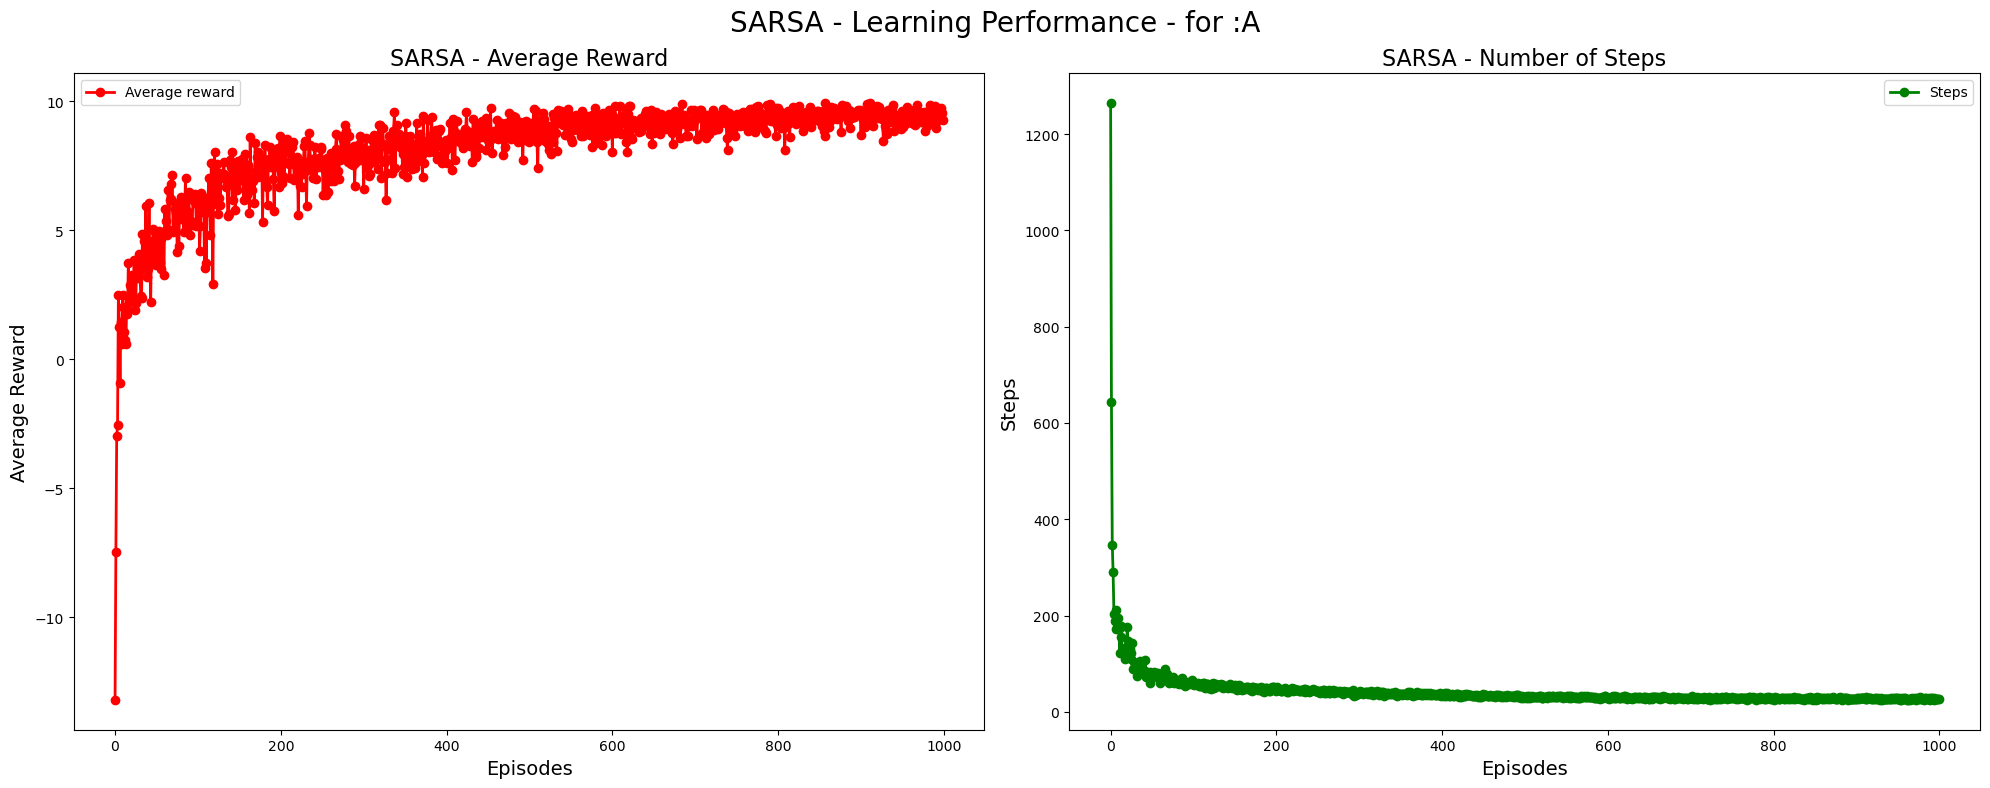

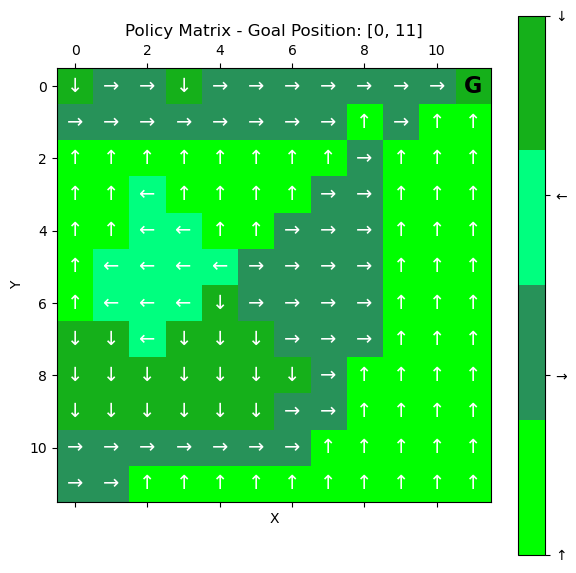

100%|██████████| 1000/1000 [00:03<00:00, 322.99it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 22.0


Episode                                         Avg Reward  \
0          1  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   
1          2  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   
2          3  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   
3          4  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   
4          5  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   
..       ...                                                ...   
995      996  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   
996      997  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   
997      998  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   
998      999  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   
999     1000  [-2.0, 2.0, 2.0, -2.0, 1.0, -7.0, 0.0, 0.0, 6....   

     Number of Steps  
0             1806.0  
1             2219.0  
2             1852.0  
3              353.0  
4              502.0  
..               ...  
995             34.0  
996             26.0  
997             11.0  
998             39.0  
999             22.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 402.73it/s]

-----------All episodes done-----------
Episode 1000: Total reward = -13.0, Number of steps = 38.0


Episode                                         Avg Reward  \
0          1  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   
1          2  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   
2          3  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   
3          4  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   
4          5  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   
..       ...                                                ...   
995      996  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   
996      997  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   
997      998  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   
998      999  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   
999     1000  [-8.0, -13.0, 0.0, 8.0, -3.0, -6.0, 6.0, 3.0, ...   

     Number of Steps  
0              757.0  
1              406.0  
2              599.0  
3              141.0  
4              328.0  
..               ...  
995             29.0  
996             16.0  
997             40.0  
998             23.0  
999             38.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 347.71it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0          1  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   
1          2  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   
2          3  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   
3          4  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   
4          5  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   
..       ...                                                ...   
995      996  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   
996      997  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   
997      998  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   
998      999  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   
999     1000  [-9.0, -4.0, 9.0, 5.0, -18.0, 9.0, -5.0, 8.0, ...   

     Number of Steps  
0             1395.0  
1              290.0  
2              126.0  
3              369.0  
4               56.0  
..               ...  
995             34.0  
996             22.0  
997             40.0  
998             18.0  
999             21.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 355.24it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 41.0


Episode                                         Avg Reward  \
0          1  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   
1          2  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   
2          3  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   
3          4  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   
4          5  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   
..       ...                                                ...   
995      996  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   
996      997  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   
997      998  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   
998      999  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   
999     1000  [-29.0, -14.0, -10.0, -10.0, -15.0, 8.0, -5.0,...   

     Number of Steps  
0             2733.0  
1               97.0  
2              325.0  
3               90.0  
4              434.0  
..               ...  
995             39.0  
996             27.0  
997             31.0  
998             25.0  
999             41.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 343.28it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0          1  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   
1          2  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   
2          3  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   
3          4  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   
4          5  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   
..       ...                                                ...   
995      996  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   
996      997  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   
997      998  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   
998      999  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   
999     1000  [-1.0, -3.0, 0.0, 8.0, -6.0, 0.0, 4.0, -13.0, ...   

     Number of Steps  
0              513.0  
1               19.0  
2             1338.0  
3              444.0  
4              595.0  
..               ...  
995             30.0  
996             33.0  
997             20.0  
998             43.0  
999             14.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 357.78it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 11.0


Episode                                         Avg Reward  \
0          1  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   
1          2  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   
2          3  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   
3          4  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   
4          5  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   
..       ...                                                ...   
995      996  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   
996      997  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   
997      998  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   
998      999  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   
999     1000  [4.0, -16.0, 7.0, -18.0, 9.0, 9.0, -6.0, -11.0...   

     Number of Steps  
0              674.0  
1              628.0  
2              242.0  
3              323.0  
4              604.0  
..               ...  
995             21.0  
996             11.0  
997             40.0  
998             32.0  
999             11.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 336.13it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   
1          2  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   
2          3  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   
3          4  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   
4          5  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   
..       ...                                                ...   
995      996  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   
996      997  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   
997      998  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   
998      999  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   
999     1000  [-24.0, 10.0, 6.0, 6.0, -17.0, 10.0, 7.0, 5.0,...   

     Number of Steps  
0             2671.0  
1              198.0  
2              193.0  
3              349.0  
4              329.0  
..               ...  
995             16.0  
996             25.0  
997             37.0  
998             35.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 387.29it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode                                         Avg Reward  \
0          1  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   
1          2  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   
2          3  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   
3          4  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   
4          5  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   
..       ...                                                ...   
995      996  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   
996      997  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   
997      998  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   
998      999  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   
999     1000  [4.0, -8.0, 9.0, 10.0, 10.0, -1.0, 10.0, -5.0,...   

     Number of Steps  
0              430.0  
1              280.0  
2              262.0  
3               75.0  
4              165.0  
..               ...  
995             51.0  
996             17.0  
997             23.0  
998             28.0  
999             29.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 339.83it/s]


-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0          1  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   
1          2  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   
2          3  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   
3          4  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   
4          5  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   
..       ...                                                ...   
995      996  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   
996      997  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   
997      998  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   
998      999  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   
999     1000  [-22.0, 1.0, -5.0, -12.0, 9.0, 7.0, -16.0, 9.0...   

     Number of Steps  
0              368.0  
1              352.0  
2             3136.0  
3               40.0  
4              205.0  
..               ...  
995             37.0  
996             19.0  
997             44.0  
998             18.0  
999             19.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 408.50it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0          1  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   
1          2  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   
2          3  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   
3          4  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   
4          5  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   
..       ...                                                ...   
995      996  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   
996      997  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   
997      998  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   
998      999  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   
999     1000  [-4.0, -3.0, 7.0, 10.0, 10.0, 9.0, 5.0, 10.0, ...   

     Number of Steps  
0              247.0  
1               91.0  
2               57.0  
3              227.0  
4              214.0  
..               ...  
995             38.0  
996             25.0  
997             27.0  
998             32.0  
999             16.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 407.00it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 2.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0          1  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   
1          2  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   
2          3  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   
3          4  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   
4          5  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   
..       ...                                                ...   
995      996  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   
996      997  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   
997      998  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   
998      999  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   
999     1000  [10.0, 4.0, 9.0, 0.0, -21.0, -1.0, 10.0, 8.0, ...   

     Number of Steps  
0               78.0  
1               30.0  
2               91.0  
3              109.0  
4               51.0  
..               ...  
995             26.0  
996             25.0  
997             24.0  
998             28.0  
999             18.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 313.61it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 35.0


Episode                                         Avg Reward  \
0          1  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   
1          2  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   
2          3  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   
3          4  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   
4          5  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   
..       ...                                                ...   
995      996  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   
996      997  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   
997      998  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   
998      999  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   
999     1000  [-35.0, -7.0, 5.0, -1.0, 2.0, -9.0, 2.0, -8.0,...   

     Number of Steps  
0             1806.0  
1              492.0  
2             1149.0  
3              212.0  
4              687.0  
..               ...  
995             46.0  
996             34.0  
997             31.0  
998             25.0  
999             35.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 366.30it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 2.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   
1          2  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   
2          3  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   
3          4  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   
4          5  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   
..       ...                                                ...   
995      996  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   
996      997  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   
997      998  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   
998      999  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   
999     1000  [-2.0, -1.0, -38.0, -6.0, -37.0, 7.0, 9.0, 0.0...   

     Number of Steps  
0              242.0  
1              369.0  
2              173.0  
3              265.0  
4               47.0  
..               ...  
995             28.0  
996             41.0  
997             30.0  
998             28.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 285.55it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 6.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0          1  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   
1          2  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   
2          3  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   
3          4  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   
4          5  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   
..       ...                                                ...   
995      996  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   
996      997  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   
997      998  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   
998      999  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   
999     1000  [-54.0, -10.0, -11.0, 10.0, -17.0, 6.0, 10.0, ...   

     Number of Steps  
0             4504.0  
1              365.0  
2               34.0  
3              488.0  
4              729.0  
..               ...  
995             25.0  
996             16.0  
997             23.0  
998             39.0  
999             20.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 358.04it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0          1  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   
1          2  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   
2          3  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   
3          4  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   
4          5  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   
..       ...                                                ...   
995      996  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   
996      997  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   
997      998  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   
998      999  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   
999     1000  [-19.0, -4.0, -8.0, -15.0, 10.0, 10.0, -9.0, 7...   

     Number of Steps  
0             2805.0  
1              452.0  
2              444.0  
3               50.0  
4              137.0  
..               ...  
995             23.0  
996             26.0  
997             38.0  
998             29.0  
999             26.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 333.60it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0          1  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   
1          2  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   
2          3  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   
3          4  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   
4          5  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   
..       ...                                                ...   
995      996  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   
996      997  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   
997      998  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   
998      999  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   
999     1000  [-14.0, -11.0, -5.0, -34.0, 9.0, -23.0, 10.0, ...   

     Number of Steps  
0              154.0  
1              535.0  
2              161.0  
3              111.0  
4              172.0  
..               ...  
995             37.0  
996             20.0  
997             46.0  
998             26.0  
999             23.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 355.48it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0          1  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   
1          2  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   
2          3  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   
3          4  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   
4          5  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   
..       ...                                                ...   
995      996  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   
996      997  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   
997      998  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   
998      999  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   
999     1000  [10.0, 2.0, 0.0, 10.0, 9.0, 8.0, -3.0, 10.0, -...   

     Number of Steps  
0              134.0  
1              360.0  
2               85.0  
3               62.0  
4              113.0  
..               ...  
995             12.0  
996             18.0  
997             20.0  
998             17.0  
999             12.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 335.57it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 28.0


Episode                                         Avg Reward  \
0          1  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   
1          2  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   
2          3  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   
3          4  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   
4          5  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   
..       ...                                                ...   
995      996  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   
996      997  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   
997      998  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   
998      999  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   
999     1000  [-28.0, 2.0, -11.0, 7.0, 5.0, 5.0, -8.0, -18.0...   

     Number of Steps  
0             5095.0  
1              345.0  
2               56.0  
3              540.0  
4               49.0  
..               ...  
995             36.0  
996             33.0  
997             30.0  
998             37.0  
999             28.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 355.24it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0          1  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   
1          2  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   
2          3  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   
3          4  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   
4          5  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   
..       ...                                                ...   
995      996  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   
996      997  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   
997      998  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   
998      999  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   
999     1000  [-11.0, -22.0, 3.0, -13.0, 6.0, -20.0, -9.0, -...   

     Number of Steps  
0             3004.0  
1              986.0  
2               22.0  
3              216.0  
4               15.0  
..               ...  
995             19.0  
996             17.0  
997             25.0  
998             38.0  
999             24.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 332.33it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 36.0


Episode                                         Avg Reward  \
0          1  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   
1          2  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   
2          3  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   
3          4  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   
4          5  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   
..       ...                                                ...   
995      996  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   
996      997  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   
997      998  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   
998      999  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   
999     1000  [-37.0, 5.0, -2.0, 0.0, 10.0, 5.0, 10.0, 7.0, ...   

     Number of Steps  
0              231.0  
1              752.0  
2             1218.0  
3              234.0  
4               76.0  
..               ...  
995             37.0  
996             24.0  
997             29.0  
998             37.0  
999             36.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 302.93it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0          1  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   
1          2  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   
2          3  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   
3          4  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   
4          5  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   
..       ...                                                ...   
995      996  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   
996      997  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   
997      998  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   
998      999  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   
999     1000  [-19.0, 8.0, 2.0, 5.0, 9.0, 10.0, 8.0, 9.0, 10...   

     Number of Steps  
0              525.0  
1              203.0  
2              769.0  
3              748.0  
4              506.0  
..               ...  
995             44.0  
996             26.0  
997             18.0  
998             24.0  
999             27.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 325.95it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0          1  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   
1          2  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   
2          3  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   
3          4  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   
4          5  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   
..       ...                                                ...   
995      996  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   
996      997  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   
997      998  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   
998      999  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   
999     1000  [-33.0, -3.0, -4.0, -3.0, 10.0, 5.0, 1.0, -8.0...   

     Number of Steps  
0             2269.0  
1             1023.0  
2              165.0  
3               56.0  
4               63.0  
..               ...  
995             38.0  
996             29.0  
997             21.0  
998             28.0  
999             26.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 341.41it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 33.0


Episode                                         Avg Reward  \
0          1  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   
1          2  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   
2          3  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   
3          4  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   
4          5  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   
..       ...                                                ...   
995      996  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   
996      997  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   
997      998  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   
998      999  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   
999     1000  [-2.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, -26....   

     Number of Steps  
0             1379.0  
1               87.0  
2              477.0  
3              254.0  
4              104.0  
..               ...  
995             37.0  
996             34.0  
997             30.0  
998             37.0  
999             33.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 285.59it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 5.0, Number of steps = 40.0


Episode                                         Avg Reward  \
0          1  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   
1          2  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   
2          3  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   
3          4  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   
4          5  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   
..       ...                                                ...   
995      996  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   
996      997  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   
997      998  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   
998      999  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   
999     1000  [-4.0, -61.0, 3.0, -1.0, 7.0, 9.0, 8.0, 10.0, ...   

     Number of Steps  
0              571.0  
1             3346.0  
2              374.0  
3              814.0  
4              308.0  
..               ...  
995             22.0  
996             32.0  
997             25.0  
998             41.0  
999             40.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 296.69it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 10.0


Episode                                         Avg Reward  \
0          1  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   
1          2  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   
2          3  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   
3          4  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   
4          5  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   
..       ...                                                ...   
995      996  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   
996      997  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   
997      998  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   
998      999  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   
999     1000  [-66.0, -11.0, -3.0, 9.0, 4.0, 8.0, 1.0, -1.0,...   

     Number of Steps  
0             5032.0  
1               69.0  
2              219.0  
3              304.0  
4              288.0  
..               ...  
995             27.0  
996             40.0  
997             31.0  
998             24.0  
999             10.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 357.27it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0          1  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   
1          2  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   
2          3  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   
3          4  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   
4          5  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   
..       ...                                                ...   
995      996  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   
996      997  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   
997      998  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   
998      999  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   
999     1000  [-15.0, 6.0, -9.0, 9.0, -9.0, -10.0, 9.0, 10.0...   

     Number of Steps  
0               56.0  
1              172.0  
2               45.0  
3               99.0  
4               46.0  
..               ...  
995             23.0  
996             22.0  
997             31.0  
998             26.0  
999             18.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 334.00it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0          1  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   
1          2  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   
2          3  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   
3          4  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   
4          5  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   
..       ...                                                ...   
995      996  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   
996      997  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   
997      998  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   
998      999  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   
999     1000  [-14.0, -2.0, 0.0, -12.0, -21.0, 6.0, -5.0, -2...   

     Number of Steps  
0              147.0  
1             1348.0  
2             1069.0  
3              224.0  
4               83.0  
..               ...  
995             46.0  
996             14.0  
997             31.0  
998             22.0  
999             27.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 339.33it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0          1  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   
1          2  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   
2          3  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   
3          4  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   
4          5  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   
..       ...                                                ...   
995      996  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   
996      997  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   
997      998  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   
998      999  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   
999     1000  [-6.0, -20.0, 5.0, -1.0, -12.0, -13.0, -18.0, ...   

     Number of Steps  
0              303.0  
1              499.0  
2              623.0  
3              648.0  
4               59.0  
..               ...  
995             28.0  
996             15.0  
997             26.0  
998             28.0  
999             16.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 336.22it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0          1  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   
1          2  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   
2          3  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   
3          4  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   
4          5  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   
..       ...                                                ...   
995      996  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   
996      997  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   
997      998  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   
998      999  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   
999     1000  [-13.0, 4.0, 7.0, -3.0, -6.0, -31.0, 8.0, -1.0...   

     Number of Steps  
0             2376.0  
1              647.0  
2              205.0  
3              388.0  
4               30.0  
..               ...  
995             25.0  
996             26.0  
997             26.0  
998             27.0  
999             27.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 342.93it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 41.0


Episode                                         Avg Reward  \
0          1  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   
1          2  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   
2          3  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   
3          4  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   
4          5  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   
..       ...                                                ...   
995      996  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   
996      997  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   
997      998  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   
998      999  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   
999     1000  [-24.0, -9.0, 9.0, 3.0, -19.0, 0.0, -14.0, -4....   

     Number of Steps  
0             2553.0  
1              412.0  
2              419.0  
3              189.0  
4              118.0  
..               ...  
995             14.0  
996             27.0  
997             19.0  
998             28.0  
999             41.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 316.46it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0          1  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   
1          2  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   
2          3  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   
3          4  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   
4          5  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   
..       ...                                                ...   
995      996  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   
996      997  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   
997      998  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   
998      999  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   
999     1000  [-25.0, -3.0, 7.0, 4.0, -7.0, -6.0, -23.0, -5....   

     Number of Steps  
0              637.0  
1              235.0  
2              710.0  
3              248.0  
4             2151.0  
..               ...  
995             21.0  
996             51.0  
997             35.0  
998             30.0  
999             14.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 317.41it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 40.0


Episode                                         Avg Reward  \
0          1  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   
1          2  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   
2          3  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   
3          4  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   
4          5  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   
..       ...                                                ...   
995      996  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   
996      997  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   
997      998  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   
998      999  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   
999     1000  [-51.0, 4.0, -1.0, -5.0, -8.0, -10.0, 10.0, 9....   

     Number of Steps  
0             2174.0  
1              626.0  
2              622.0  
3               76.0  
4              174.0  
..               ...  
995             24.0  
996             28.0  
997             27.0  
998             27.0  
999             40.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 318.37it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 42.0


Episode                                         Avg Reward  \
0          1  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   
1          2  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   
2          3  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   
3          4  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   
4          5  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   
..       ...                                                ...   
995      996  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   
996      997  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   
997      998  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   
998      999  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   
999     1000  [-10.0, -5.0, 8.0, -110.0, 1.0, 8.0, 9.0, 3.0,...   

     Number of Steps  
0              385.0  
1               19.0  
2              392.0  
3             6264.0  
4              968.0  
..               ...  
995             13.0  
996             33.0  
997             24.0  
998             26.0  
999             42.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 374.95it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0          1  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   
1          2  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   
2          3  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   
3          4  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   
4          5  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   
..       ...                                                ...   
995      996  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   
996      997  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   
997      998  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   
998      999  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   
999     1000  [-12.0, -9.0, -14.0, 10.0, 10.0, 3.0, 1.0, 5.0...   

     Number of Steps  
0               48.0  
1               35.0  
2              242.0  
3              509.0  
4              147.0  
..               ...  
995             30.0  
996             31.0  
997             45.0  
998             26.0  
999             23.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 382.41it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 32.0


Episode                                         Avg Reward  \
0          1  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   
1          2  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   
2          3  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   
3          4  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   
4          5  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   
..       ...                                                ...   
995      996  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   
996      997  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   
997      998  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   
998      999  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   
999     1000  [1.0, -54.0, -1.0, -4.0, -4.0, -13.0, 10.0, -9...   

     Number of Steps  
0               33.0  
1               73.0  
2              132.0  
3               46.0  
4              922.0  
..               ...  
995             25.0  
996             48.0  
997             19.0  
998             24.0  
999             32.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 344.23it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0          1  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   
1          2  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   
2          3  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   
3          4  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   
4          5  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   
..       ...                                                ...   
995      996  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   
996      997  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   
997      998  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   
998      999  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   
999     1000  [8.0, -9.0, 10.0, -9.0, -24.0, 10.0, 10.0, 9.0...   

     Number of Steps  
0              943.0  
1              107.0  
2              123.0  
3              158.0  
4               65.0  
..               ...  
995             37.0  
996             28.0  
997             12.0  
998             29.0  
999             23.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 387.45it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   
1          2  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   
2          3  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   
3          4  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   
4          5  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   
..       ...                                                ...   
995      996  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   
996      997  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   
997      998  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   
998      999  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   
999     1000  [2.0, 8.0, 10.0, 3.0, 10.0, 7.0, -7.0, 10.0, 1...   

     Number of Steps  
0              713.0  
1              764.0  
2               75.0  
3               23.0  
4               70.0  
..               ...  
995             32.0  
996             15.0  
997             29.0  
998             35.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 350.02it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 37.0


Episode                                         Avg Reward  \
0          1  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   
1          2  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   
2          3  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   
3          4  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   
4          5  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   
..       ...                                                ...   
995      996  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   
996      997  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   
997      998  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   
998      999  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   
999     1000  [-13.0, -13.0, 6.0, 8.0, -4.0, -5.0, -8.0, -2....   

     Number of Steps  
0             2639.0  
1               27.0  
2              492.0  
3              258.0  
4               56.0  
..               ...  
995             16.0  
996             33.0  
997             30.0  
998             20.0  
999             37.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 337.83it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 29.0


Episode                                         Avg Reward  \
0          1  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   
1          2  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   
2          3  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   
3          4  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   
4          5  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   
..       ...                                                ...   
995      996  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   
996      997  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   
997      998  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   
998      999  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   
999     1000  [-44.0, 10.0, 10.0, -25.0, -5.0, -15.0, -8.0, ...   

     Number of Steps  
0              625.0  
1              263.0  
2              217.0  
3              378.0  
4              132.0  
..               ...  
995             18.0  
996             24.0  
997             21.0  
998             23.0  
999             29.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 369.41it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 32.0


Episode                                         Avg Reward  \
0          1  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   
1          2  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   
2          3  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   
3          4  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   
4          5  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   
..       ...                                                ...   
995      996  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   
996      997  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   
997      998  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   
998      999  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   
999     1000  [3.0, -32.0, 8.0, -11.0, 1.0, 9.0, 2.0, 10.0, ...   

     Number of Steps  
0             1181.0  
1             1898.0  
2              288.0  
3               36.0  
4              125.0  
..               ...  
995             24.0  
996             37.0  
997             35.0  
998             12.0  
999             32.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 369.41it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0          1  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   
1          2  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   
2          3  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   
3          4  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   
4          5  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   
..       ...                                                ...   
995      996  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   
996      997  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   
997      998  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   
998      999  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   
999     1000  [-6.0, 9.0, 8.0, -22.0, 10.0, 10.0, -3.0, 4.0,...   

     Number of Steps  
0              674.0  
1              121.0  
2              224.0  
3               82.0  
4              398.0  
..               ...  
995             25.0  
996             41.0  
997             39.0  
998             27.0  
999             27.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 334.56it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0          1  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   
1          2  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   
2          3  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   
3          4  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   
4          5  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   
..       ...                                                ...   
995      996  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   
996      997  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   
997      998  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   
998      999  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   
999     1000  [-14.0, -5.0, 6.0, -19.0, -2.0, 2.0, -15.0, -1...   

     Number of Steps  
0             1424.0  
1               10.0  
2              190.0  
3              126.0  
4               23.0  
..               ...  
995             24.0  
996             35.0  
997             25.0  
998             36.0  
999             19.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 327.81it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0          1  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   
1          2  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   
2          3  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   
3          4  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   
4          5  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   
..       ...                                                ...   
995      996  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   
996      997  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   
997      998  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   
998      999  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   
999     1000  [6.0, -5.0, -4.0, 0.0, 8.0, -5.0, -11.0, -5.0,...   

     Number of Steps  
0             1431.0  
1              162.0  
2              714.0  
3               92.0  
4              254.0  
..               ...  
995             35.0  
996             28.0  
997             15.0  
998             14.0  
999             12.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 324.07it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 54.0


Episode                                         Avg Reward  \
0          1  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   
1          2  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   
2          3  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   
3          4  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   
4          5  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   
..       ...                                                ...   
995      996  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   
996      997  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   
997      998  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   
998      999  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   
999     1000  [6.0, -5.0, 8.0, -5.0, 10.0, 7.0, -4.0, -10.0,...   

     Number of Steps  
0             1637.0  
1              563.0  
2              126.0  
3               22.0  
4              192.0  
..               ...  
995             54.0  
996             34.0  
997             33.0  
998             14.0  
999             54.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 340.77it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 35.0


Episode                                         Avg Reward  \
0          1  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   
1          2  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   
2          3  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   
3          4  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   
4          5  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   
..       ...                                                ...   
995      996  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   
996      997  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   
997      998  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   
998      999  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   
999     1000  [2.0, -14.0, 1.0, 10.0, -1.0, -1.0, -4.0, 1.0,...   

     Number of Steps  
0              381.0  
1             1690.0  
2               66.0  
3              138.0  
4               88.0  
..               ...  
995             23.0  
996             14.0  
997             24.0  
998             36.0  
999             35.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 332.99it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0          1  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   
1          2  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   
2          3  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   
3          4  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   
4          5  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   
..       ...                                                ...   
995      996  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   
996      997  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   
997      998  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   
998      999  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   
999     1000  [-13.0, 6.0, 3.0, -7.0, 0.0, 5.0, -26.0, 10.0,...   

     Number of Steps  
0              277.0  
1              142.0  
2              195.0  
3              203.0  
4               13.0  
..               ...  
995             36.0  
996             36.0  
997             23.0  
998             36.0  
999             24.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 310.56it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0          1  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   
1          2  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   
2          3  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   
3          4  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   
4          5  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   
..       ...                                                ...   
995      996  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   
996      997  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   
997      998  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   
998      999  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   
999     1000  [7.0, -7.0, 1.0, 2.0, -8.0, -14.0, -5.0, 4.0, ...   

     Number of Steps  
0              532.0  
1               34.0  
2               75.0  
3               78.0  
4              218.0  
..               ...  
995             10.0  
996             44.0  
997             26.0  
998             37.0  
999             24.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 343.76it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 32.0


Episode                                         Avg Reward  \
0          1  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   
1          2  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   
2          3  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   
3          4  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   
4          5  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   
..       ...                                                ...   
995      996  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   
996      997  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   
997      998  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   
998      999  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   
999     1000  [7.0, 7.0, 10.0, -8.0, 7.0, 10.0, -5.0, -5.0, ...   

     Number of Steps  
0             2037.0  
1              334.0  
2              177.0  
3              301.0  
4              166.0  
..               ...  
995             40.0  
996             37.0  
997             13.0  
998             24.0  
999             32.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 309.50it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 50.0


Episode                                         Avg Reward  \
0          1  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   
1          2  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   
2          3  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   
3          4  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   
4          5  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   
..       ...                                                ...   
995      996  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   
996      997  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   
997      998  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   
998      999  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   
999     1000  [0.0, -7.0, 10.0, 5.0, 0.0, -5.0, -21.0, 7.0, ...   

     Number of Steps  
0              578.0  
1              325.0  
2              183.0  
3              579.0  
4               21.0  
..               ...  
995             28.0  
996             20.0  
997             39.0  
998             27.0  
999             50.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 302.48it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 10.0, Number of steps = 22.0


Episode                                         Avg Reward  \
0          1  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   
1          2  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   
2          3  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   
3          4  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   
4          5  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   
..       ...                                                ...   
995      996  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   
996      997  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   
997      998  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   
998      999  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   
999     1000  [-4.0, 9.0, 7.0, -1.0, 4.0, 8.0, -18.0, 10.0, ...   

     Number of Steps  
0             2856.0  
1              869.0  
2              811.0  
3              257.0  
4              411.0  
..               ...  
995             60.0  
996             35.0  
997             43.0  
998             37.0  
999             22.0  

[1000 rows x 3 columns]

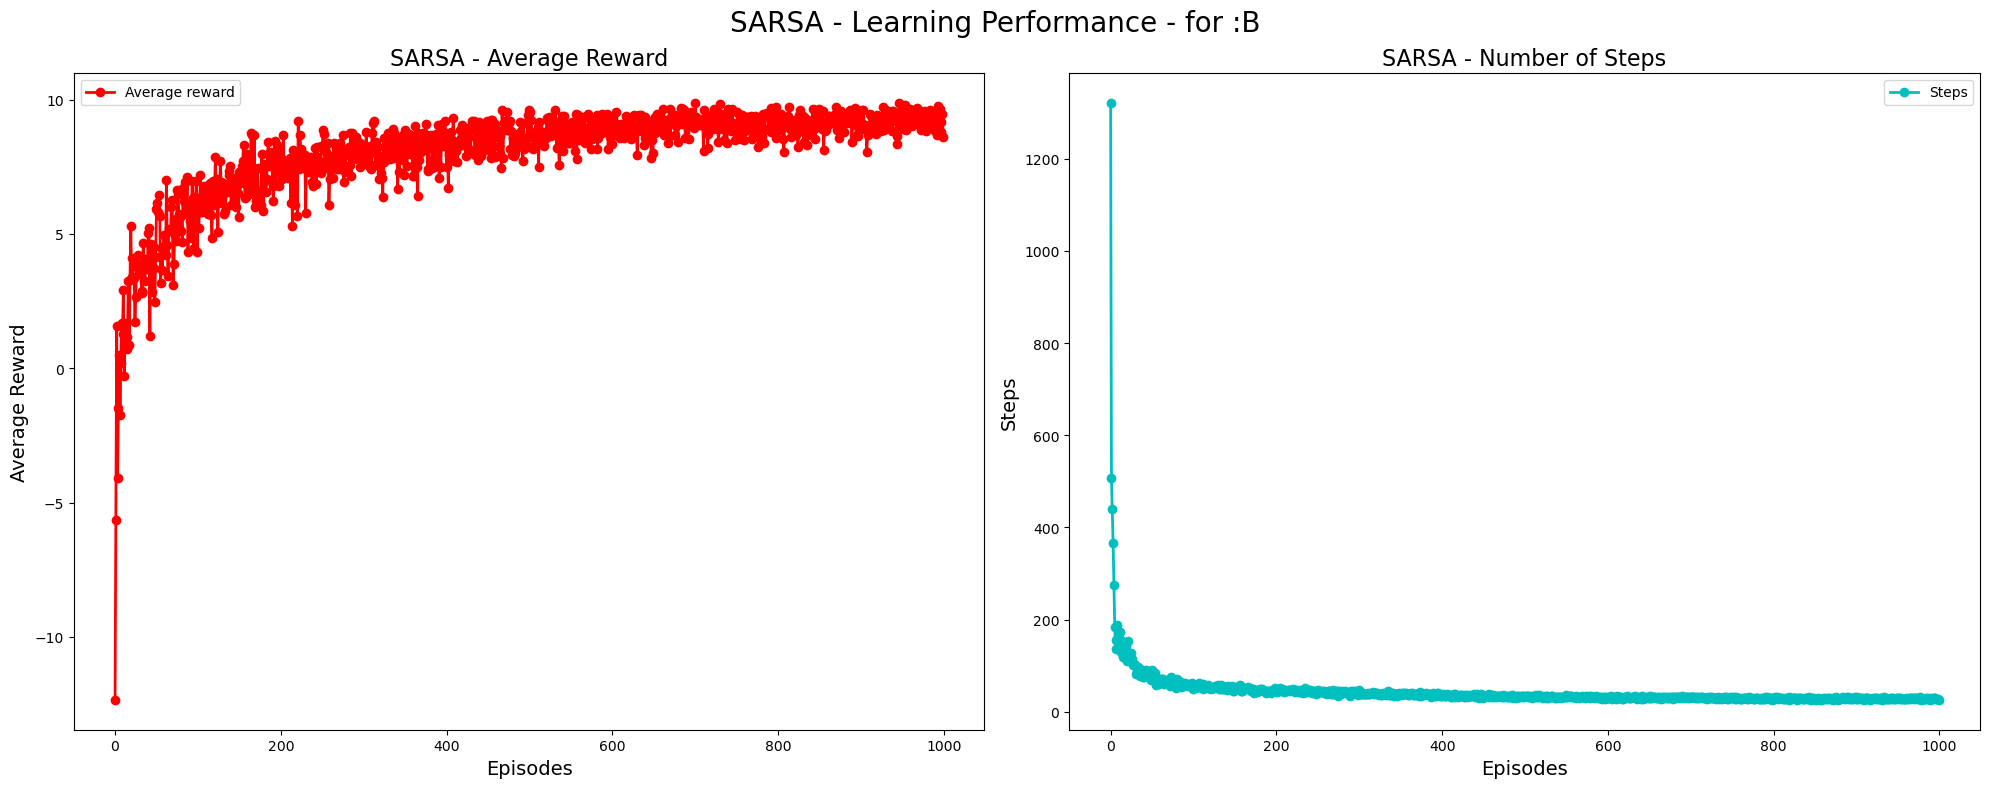

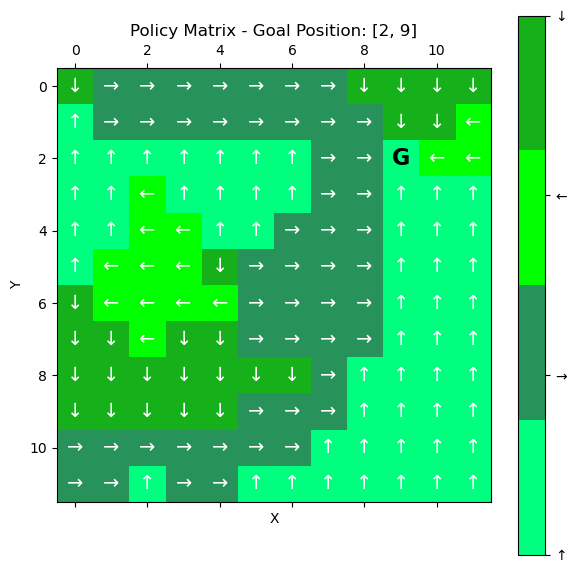

100%|██████████| 1000/1000 [00:01<00:00, 504.80it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 31.0


Episode                                         Avg Reward  \
0          1  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   
1          2  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   
2          3  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   
3          4  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   
4          5  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   
..       ...                                                ...   
995      996  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   
996      997  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   
997      998  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   
998      999  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   
999     1000  [8.0, -31.0, 3.0, -48.0, 9.0, 9.0, 3.0, 8.0, 8...   

     Number of Steps  
0              194.0  
1              403.0  
2              169.0  
3              675.0  
4               65.0  
..               ...  
995             18.0  
996             24.0  
997             20.0  
998             25.0  
999             31.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 602.77it/s] 

-----------All episodes done-----------
Episode 1000: Total reward = 2.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0          1  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   
1          2  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   
2          3  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   
3          4  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   
4          5  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   
..       ...                                                ...   
995      996  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   
996      997  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   
997      998  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   
998      999  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   
999     1000  [5.0, -73.0, -9.0, 5.0, 4.0, -2.0, 8.0, 7.0, -...   

     Number of Steps  
0              185.0  
1             2074.0  
2              566.0  
3             1054.0  
4              281.0  
..               ...  
995             24.0  
996             22.0  
997             20.0  
998             34.0  
999             21.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 395.10it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 25.0


Episode                                         Avg Reward  \
0          1  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   
1          2  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   
2          3  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   
3          4  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   
4          5  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   
..       ...                                                ...   
995      996  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   
996      997  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   
997      998  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   
998      999  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   
999     1000  [-51.0, -247.0, -2.0, -28.0, -73.0, -6.0, -2.0...   

     Number of Steps  
0               69.0  
1             6682.0  
2              970.0  
3             2606.0  
4             2758.0  
..               ...  
995             29.0  
996             25.0  
997             23.0  
998             23.0  
999             25.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 418.77it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0          1  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   
1          2  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   
2          3  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   
3          4  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   
4          5  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   
..       ...                                                ...   
995      996  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   
996      997  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   
997      998  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   
998      999  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   
999     1000  [-76.0, -28.0, -80.0, 7.0, -66.0, -36.0, 7.0, ...   

     Number of Steps  
0             1717.0  
1             2431.0  
2             1716.0  
3              414.0  
4             2360.0  
..               ...  
995             18.0  
996             37.0  
997             25.0  
998             24.0  
999             21.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 546.14it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 32.0


Episode                                         Avg Reward  \
0          1  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   
1          2  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   
2          3  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   
3          4  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   
4          5  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   
..       ...                                                ...   
995      996  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   
996      997  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   
997      998  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   
998      999  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   
999     1000  [-76.0, 8.0, -241.0, -42.0, -1.0, 9.0, 9.0, 7....   

     Number of Steps  
0             1452.0  
1              205.0  
2             7333.0  
3             1853.0  
4              340.0  
..               ...  
995             33.0  
996             17.0  
997             15.0  
998             19.0  
999             32.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 482.62it/s]

-----------All episodes done-----------
Episode 1000: Total reward = -7.0, Number of steps = 76.0


Episode                                         Avg Reward  \
0          1  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   
1          2  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   
2          3  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   
3          4  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   
4          5  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   
..       ...                                                ...   
995      996  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   
996      997  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   
997      998  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   
998      999  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   
999     1000  [-92.0, 3.0, -32.0, 7.0, 1.0, -8.0, -38.0, 0.0...   

     Number of Steps  
0             1868.0  
1              321.0  
2               57.0  
3              470.0  
4              293.0  
..               ...  
995             25.0  
996             23.0  
997             24.0  
998             24.0  
999             76.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 514.40it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 33.0


Episode                                         Avg Reward  \
0          1  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   
1          2  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   
2          3  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   
3          4  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   
4          5  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   
..       ...                                                ...   
995      996  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   
996      997  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   
997      998  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   
998      999  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   
999     1000  [-192.0, 5.0, 6.0, 7.0, 5.0, -10.0, 9.0, 7.0, ...   

     Number of Steps  
0             3322.0  
1               59.0  
2              130.0  
3              190.0  
4              392.0  
..               ...  
995             33.0  
996             25.0  
997             19.0  
998             28.0  
999             33.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 476.19it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   
1          2  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   
2          3  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   
3          4  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   
4          5  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   
..       ...                                                ...   
995      996  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   
996      997  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   
997      998  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   
998      999  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   
999     1000  [-109.0, -45.0, -5.0, -21.0, -19.0, -51.0, -17...   

     Number of Steps  
0             3571.0  
1             2525.0  
2              431.0  
3             1110.0  
4             1095.0  
..               ...  
995             24.0  
996             20.0  
997             27.0  
998             19.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 272.33it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0          1  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   
1          2  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   
2          3  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   
3          4  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   
4          5  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   
..       ...                                                ...   
995      996  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   
996      997  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   
997      998  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   
998      999  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   
999     1000  [-102.0, -27.0, -24.0, -39.0, -25.0, -39.0, -6...   

     Number of Steps  
0             1446.0  
1              411.0  
2             1035.0  
3              954.0  
4             2860.0  
..               ...  
995             32.0  
996             27.0  
997             19.0  
998             22.0  
999             27.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 418.58it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0          1  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   
1          2  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   
2          3  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   
3          4  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   
4          5  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   
..       ...                                                ...   
995      996  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   
996      997  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   
997      998  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   
998      999  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   
999     1000  [-45.0, -171.0, -2.0, 2.0, -5.0, 6.0, 4.0, -20...   

     Number of Steps  
0              216.0  
1             4770.0  
2              520.0  
3              284.0  
4              196.0  
..               ...  
995             31.0  
996             17.0  
997             16.0  
998             21.0  
999             20.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 514.93it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0          1  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   
1          2  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   
2          3  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   
3          4  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   
4          5  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   
..       ...                                                ...   
995      996  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   
996      997  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   
997      998  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   
998      999  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   
999     1000  [-1.0, -1.0, -13.0, -21.0, -5.0, -20.0, -2.0, ...   

     Number of Steps  
0              376.0  
1              809.0  
2              198.0  
3              154.0  
4              543.0  
..               ...  
995             21.0  
996             25.0  
997             20.0  
998             21.0  
999             21.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 501.49it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   
1          2  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   
2          3  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   
3          4  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   
4          5  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   
..       ...                                                ...   
995      996  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   
996      997  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   
997      998  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   
998      999  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   
999     1000  [-13.0, -7.0, -19.0, 8.0, 8.0, 9.0, 9.0, 3.0, ...   

     Number of Steps  
0               16.0  
1               12.0  
2              984.0  
3              238.0  
4              332.0  
..               ...  
995             26.0  
996             24.0  
997             21.0  
998             15.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:06<00:00, 157.23it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0          1  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   
1          2  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   
2          3  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   
3          4  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   
4          5  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   
..       ...                                                ...   
995      996  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   
996      997  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   
997      998  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   
998      999  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   
999     1000  [-264.0, -6.0, -339.0, -51.0, -19.0, -38.0, -4...   

     Number of Steps  
0             9779.0  
1              367.0  
2            15776.0  
3             3731.0  
4             2335.0  
..               ...  
995             37.0  
996             28.0  
997             35.0  
998             31.0  
999             23.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 528.81it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0          1  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   
1          2  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   
2          3  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   
3          4  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   
4          5  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   
..       ...                                                ...   
995      996  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   
996      997  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   
997      998  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   
998      999  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   
999     1000  [-46.0, -110.0, -30.0, 8.0, 9.0, 5.0, -68.0, 5...   

     Number of Steps  
0              188.0  
1             2493.0  
2             2440.0  
3              166.0  
4              264.0  
..               ...  
995             19.0  
996             22.0  
997             12.0  
998             13.0  
999             19.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 347.22it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 4.0, Number of steps = 22.0


Episode                                         Avg Reward  \
0          1  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   
1          2  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   
2          3  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   
3          4  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   
4          5  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   
..       ...                                                ...   
995      996  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   
996      997  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   
997      998  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   
998      999  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   
999     1000  [-49.0, -28.0, -222.0, -121.0, -34.0, -122.0, ...   

     Number of Steps  
0             1020.0  
1             1477.0  
2             4422.0  
3             2294.0  
4              744.0  
..               ...  
995             33.0  
996             26.0  
997             26.0  
998             23.0  
999             22.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 292.91it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 22.0


Episode                                         Avg Reward  \
0          1  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   
1          2  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   
2          3  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   
3          4  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   
4          5  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   
..       ...                                                ...   
995      996  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   
996      997  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   
997      998  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   
998      999  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   
999     1000  [-255.0, -433.0, -38.0, 4.0, -37.0, -4.0, 2.0,...   

     Number of Steps  
0             5846.0  
1            24420.0  
2             4306.0  
3              422.0  
4             3141.0  
..               ...  
995             22.0  
996             25.0  
997             22.0  
998             20.0  
999             22.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 432.15it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0          1  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   
1          2  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   
2          3  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   
3          4  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   
4          5  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   
..       ...                                                ...   
995      996  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   
996      997  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   
997      998  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   
998      999  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   
999     1000  [-32.0, -55.0, -132.0, -25.0, -7.0, -41.0, -10...   

     Number of Steps  
0              481.0  
1             3587.0  
2             2213.0  
3             2642.0  
4              463.0  
..               ...  
995             29.0  
996             27.0  
997             25.0  
998             19.0  
999             20.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:03<00:00, 290.69it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 38.0


Episode                                         Avg Reward  \
0          1  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   
1          2  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   
2          3  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   
3          4  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   
4          5  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   
..       ...                                                ...   
995      996  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   
996      997  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   
997      998  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   
998      999  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   
999     1000  [-761.0, -112.0, -95.0, -47.0, -6.0, 6.0, 9.0,...   

     Number of Steps  
0            21325.0  
1             7805.0  
2             8355.0  
3             5153.0  
4             2472.0  
..               ...  
995             19.0  
996             67.0  
997             28.0  
998             32.0  
999             38.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 545.55it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0          1  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   
1          2  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   
2          3  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   
3          4  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   
4          5  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   
..       ...                                                ...   
995      996  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   
996      997  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   
997      998  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   
998      999  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   
999     1000  [-86.0, -314.0, -8.0, 9.0, 2.0, 7.0, -2.0, 9.0...   

     Number of Steps  
0              521.0  
1            10149.0  
2              327.0  
3               94.0  
4               16.0  
..               ...  
995             17.0  
996             19.0  
997             14.0  
998             15.0  
999             18.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 440.14it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0          1  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   
1          2  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   
2          3  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   
3          4  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   
4          5  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   
..       ...                                                ...   
995      996  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   
996      997  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   
997      998  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   
998      999  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   
999     1000  [-10.0, -6.0, -34.0, -59.0, 6.0, -11.0, -22.0,...   

     Number of Steps  
0              485.0  
1              666.0  
2             1600.0  
3              696.0  
4              353.0  
..               ...  
995             20.0  
996             12.0  
997             20.0  
998             21.0  
999             13.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 494.56it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0          1  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   
1          2  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   
2          3  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   
3          4  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   
4          5  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   
..       ...                                                ...   
995      996  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   
996      997  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   
997      998  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   
998      999  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   
999     1000  [-224.0, -106.0, -22.0, 4.0, 8.0, -4.0, 8.0, 9...   

     Number of Steps  
0             4525.0  
1             2820.0  
2             1133.0  
3              944.0  
4              151.0  
..               ...  
995             28.0  
996             23.0  
997             17.0  
998             22.0  
999             15.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 471.14it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0          1  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   
1          2  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   
2          3  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   
3          4  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   
4          5  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   
..       ...                                                ...   
995      996  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   
996      997  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   
997      998  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   
998      999  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   
999     1000  [-59.0, -17.0, -49.0, -119.0, -6.0, 8.0, 1.0, ...   

     Number of Steps  
0             2624.0  
1              905.0  
2             4703.0  
3             9089.0  
4             1999.0  
..               ...  
995             11.0  
996             17.0  
997             19.0  
998             19.0  
999             18.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 628.93it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 22.0


Episode                                         Avg Reward  \
0          1  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   
1          2  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   
2          3  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   
3          4  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   
4          5  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   
..       ...                                                ...   
995      996  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   
996      997  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   
997      998  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   
998      999  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   
999     1000  [-31.0, -12.0, -83.0, -22.0, -43.0, -2.0, -28....   

     Number of Steps  
0              206.0  
1               22.0  
2              188.0  
3             1822.0  
4             1126.0  
..               ...  
995             20.0  
996             13.0  
997             18.0  
998             29.0  
999             22.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 464.46it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 25.0


Episode                                         Avg Reward  \
0          1  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   
1          2  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   
2          3  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   
3          4  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   
4          5  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   
..       ...                                                ...   
995      996  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   
996      997  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   
997      998  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   
998      999  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   
999     1000  [-77.0, -26.0, 7.0, 5.0, 7.0, 7.0, -13.0, 7.0,...   

     Number of Steps  
0             1584.0  
1              235.0  
2              350.0  
3              120.0  
4              147.0  
..               ...  
995             19.0  
996             22.0  
997             30.0  
998             30.0  
999             25.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 519.13it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0          1  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   
1          2  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   
2          3  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   
3          4  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   
4          5  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   
..       ...                                                ...   
995      996  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   
996      997  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   
997      998  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   
998      999  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   
999     1000  [-11.0, -4.0, -3.0, 6.0, -1.0, 7.0, -4.0, -6.0...   

     Number of Steps  
0             1024.0  
1             1157.0  
2              282.0  
3              809.0  
4              139.0  
..               ...  
995             26.0  
996             23.0  
997             14.0  
998             19.0  
999             16.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 477.56it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0          1  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   
1          2  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   
2          3  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   
3          4  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   
4          5  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   
..       ...                                                ...   
995      996  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   
996      997  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   
997      998  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   
998      999  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   
999     1000  [-182.0, -91.0, 8.0, -2.0, 2.0, 8.0, -24.0, 8....   

     Number of Steps  
0             3199.0  
1             4194.0  
2              825.0  
3              462.0  
4              765.0  
..               ...  
995             32.0  
996             31.0  
997             36.0  
998             24.0  
999             18.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 588.24it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0          1  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   
1          2  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   
2          3  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   
3          4  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   
4          5  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   
..       ...                                                ...   
995      996  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   
996      997  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   
997      998  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   
998      999  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   
999     1000  [-111.0, -17.0, 3.0, -22.0, 2.0, 9.0, -32.0, 3...   

     Number of Steps  
0              750.0  
1             2162.0  
2              494.0  
3              726.0  
4              596.0  
..               ...  
995             22.0  
996             23.0  
997             18.0  
998             15.0  
999             16.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 490.97it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0          1  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   
1          2  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   
2          3  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   
3          4  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   
4          5  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   
..       ...                                                ...   
995      996  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   
996      997  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   
997      998  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   
998      999  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   
999     1000  [-20.0, -145.0, 0.0, -11.0, 7.0, -58.0, -24.0,...   

     Number of Steps  
0              559.0  
1             4900.0  
2              389.0  
3              562.0  
4              510.0  
..               ...  
995             25.0  
996             25.0  
997             23.0  
998             22.0  
999             16.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:04<00:00, 236.35it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   
1          2  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   
2          3  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   
3          4  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   
4          5  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   
..       ...                                                ...   
995      996  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   
996      997  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   
997      998  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   
998      999  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   
999     1000  [-50.0, -25.0, -322.0, -26.0, 1.0, -81.0, -115...   

     Number of Steps  
0             1960.0  
1              860.0  
2            14421.0  
3             1890.0  
4              686.0  
..               ...  
995             31.0  
996             35.0  
997             21.0  
998             33.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 450.74it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0          1  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   
1          2  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   
2          3  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   
3          4  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   
4          5  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   
..       ...                                                ...   
995      996  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   
996      997  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   
997      998  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   
998      999  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   
999     1000  [-61.0, 7.0, -87.0, 5.0, 0.0, -170.0, -52.0, 1...   

     Number of Steps  
0             2204.0  
1              161.0  
2             1646.0  
3              326.0  
4              108.0  
..               ...  
995             21.0  
996             23.0  
997             23.0  
998             25.0  
999             24.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 429.55it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0          1  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   
1          2  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   
2          3  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   
3          4  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   
4          5  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   
..       ...                                                ...   
995      996  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   
996      997  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   
997      998  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   
998      999  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   
999     1000  [-105.0, -36.0, -24.0, -105.0, -20.0, -40.0, -...   

     Number of Steps  
0             4478.0  
1             2125.0  
2              258.0  
3             1456.0  
4             1134.0  
..               ...  
995             25.0  
996             21.0  
997             34.0  
998             22.0  
999             21.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 383.29it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0          1  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   
1          2  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   
2          3  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   
3          4  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   
4          5  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   
..       ...                                                ...   
995      996  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   
996      997  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   
997      998  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   
998      999  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   
999     1000  [-108.0, -167.0, -63.0, -66.0, 7.0, -1.0, -8.0...   

     Number of Steps  
0             4350.0  
1             6334.0  
2             4587.0  
3             1715.0  
4              961.0  
..               ...  
995             27.0  
996             21.0  
997             38.0  
998             27.0  
999             15.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 564.65it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0          1  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   
1          2  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   
2          3  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   
3          4  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   
4          5  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   
..       ...                                                ...   
995      996  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   
996      997  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   
997      998  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   
998      999  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   
999     1000  [-18.0, 0.0, 0.0, -96.0, 9.0, -13.0, 7.0, 5.0,...   

     Number of Steps  
0               97.0  
1               47.0  
2              302.0  
3             1853.0  
4               85.0  
..               ...  
995             21.0  
996             20.0  
997             25.0  
998             27.0  
999             15.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 348.31it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 34.0


Episode                                         Avg Reward  \
0          1  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   
1          2  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   
2          3  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   
3          4  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   
4          5  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   
..       ...                                                ...   
995      996  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   
996      997  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   
997      998  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   
998      999  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   
999     1000  [-172.0, -256.0, -25.0, -33.0, -62.0, -9.0, -3...   

     Number of Steps  
0             5358.0  
1             5439.0  
2             3468.0  
3             2933.0  
4             2808.0  
..               ...  
995             27.0  
996             24.0  
997             33.0  
998             19.0  
999             34.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 546.30it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0          1  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   
1          2  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   
2          3  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   
3          4  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   
4          5  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   
..       ...                                                ...   
995      996  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   
996      997  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   
997      998  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   
998      999  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   
999     1000  [-66.0, 9.0, -75.0, 2.0, -31.0, 8.0, -5.0, 3.0...   

     Number of Steps  
0              494.0  
1               95.0  
2             2674.0  
3              185.0  
4             1542.0  
..               ...  
995             25.0  
996             31.0  
997             29.0  
998             24.0  
999             19.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 356.00it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   
1          2  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   
2          3  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   
3          4  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   
4          5  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   
..       ...                                                ...   
995      996  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   
996      997  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   
997      998  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   
998      999  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   
999     1000  [-194.0, -309.0, 7.0, 8.0, -1.0, 9.0, -16.0, 8...   

     Number of Steps  
0             3362.0  
1            14792.0  
2              287.0  
3              155.0  
4              325.0  
..               ...  
995             24.0  
996             15.0  
997             26.0  
998             26.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 521.11it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 34.0


Episode                                         Avg Reward  \
0          1  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   
1          2  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   
2          3  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   
3          4  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   
4          5  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   
..       ...                                                ...   
995      996  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   
996      997  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   
997      998  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   
998      999  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   
999     1000  [-377.0, 7.0, 9.0, 5.0, 8.0, 2.0, 8.0, 1.0, -5...   

     Number of Steps  
0            13633.0  
1              223.0  
2              194.0  
3              130.0  
4              138.0  
..               ...  
995             21.0  
996             18.0  
997             20.0  
998             38.0  
999             34.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 509.68it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0          1  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   
1          2  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   
2          3  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   
3          4  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   
4          5  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   
..       ...                                                ...   
995      996  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   
996      997  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   
997      998  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   
998      999  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   
999     1000  [-234.0, -49.0, -40.0, 1.0, -54.0, 3.0, -8.0, ...   

     Number of Steps  
0             3151.0  
1             1208.0  
2             2892.0  
3              174.0  
4             4108.0  
..               ...  
995             11.0  
996             21.0  
997             12.0  
998             16.0  
999             14.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 480.07it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0          1  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   
1          2  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   
2          3  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   
3          4  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   
4          5  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   
..       ...                                                ...   
995      996  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   
996      997  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   
997      998  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   
998      999  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   
999     1000  [-74.0, 4.0, -94.0, 0.0, -12.0, -51.0, 7.0, 5....   

     Number of Steps  
0              677.0  
1              124.0  
2             2491.0  
3              513.0  
4             1410.0  
..               ...  
995             11.0  
996             17.0  
997             22.0  
998             24.0  
999             15.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 583.77it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0          1  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   
1          2  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   
2          3  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   
3          4  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   
4          5  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   
..       ...                                                ...   
995      996  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   
996      997  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   
997      998  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   
998      999  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   
999     1000  [-128.0, -142.0, 6.0, 6.0, -11.0, 4.0, -45.0, ...   

     Number of Steps  
0              414.0  
1             1569.0  
2              103.0  
3               91.0  
4              469.0  
..               ...  
995             13.0  
996             15.0  
997             19.0  
998             18.0  
999             21.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 488.75it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0          1  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   
1          2  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   
2          3  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   
3          4  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   
4          5  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   
..       ...                                                ...   
995      996  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   
996      997  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   
997      998  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   
998      999  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   
999     1000  [-49.0, -22.0, -17.0, -24.0, -37.0, -23.0, -17...   

     Number of Steps  
0             1168.0  
1              694.0  
2              165.0  
3             1465.0  
4              299.0  
..               ...  
995             16.0  
996             27.0  
997             21.0  
998             18.0  
999             18.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 566.95it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0          1  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   
1          2  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   
2          3  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   
3          4  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   
4          5  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   
..       ...                                                ...   
995      996  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   
996      997  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   
997      998  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   
998      999  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   
999     1000  [-85.0, -7.0, -31.0, -106.0, 9.0, -50.0, -47.0...   

     Number of Steps  
0              124.0  
1              887.0  
2              589.0  
3             1220.0  
4               76.0  
..               ...  
995             20.0  
996             26.0  
997             19.0  
998             15.0  
999             13.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 441.12it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0          1  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   
1          2  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   
2          3  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   
3          4  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   
4          5  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   
..       ...                                                ...   
995      996  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   
996      997  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   
997      998  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   
998      999  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   
999     1000  [-224.0, -21.0, -17.0, -18.0, -32.0, -108.0, 3...   

     Number of Steps  
0             5892.0  
1             2666.0  
2             1300.0  
3              427.0  
4             1480.0  
..               ...  
995             26.0  
996             25.0  
997             25.0  
998             24.0  
999             17.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 481.86it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0          1  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   
1          2  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   
2          3  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   
3          4  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   
4          5  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   
..       ...                                                ...   
995      996  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   
996      997  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   
997      998  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   
998      999  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   
999     1000  [-426.0, -106.0, 3.0, -7.0, 8.0, 9.0, 5.0, 9.0...   

     Number of Steps  
0             7000.0  
1             5266.0  
2              541.0  
3               67.0  
4              402.0  
..               ...  
995             18.0  
996             28.0  
997             17.0  
998             12.0  
999             13.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 484.03it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 33.0


Episode                                         Avg Reward  \
0          1  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   
1          2  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   
2          3  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   
3          4  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   
4          5  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   
..       ...                                                ...   
995      996  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   
996      997  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   
997      998  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   
998      999  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   
999     1000  [-3.0, 8.0, -6.0, -2.0, 3.0, 5.0, -4.0, -7.0, ...   

     Number of Steps  
0              112.0  
1              714.0  
2              126.0  
3               83.0  
4               36.0  
..               ...  
995             16.0  
996             18.0  
997             19.0  
998             29.0  
999             33.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 482.15it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 9.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0          1  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   
1          2  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   
2          3  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   
3          4  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   
4          5  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   
..       ...                                                ...   
995      996  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   
996      997  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   
997      998  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   
998      999  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   
999     1000  [-85.0, 9.0, -34.0, -78.0, -3.0, 1.0, -1.0, -5...   

     Number of Steps  
0               66.0  
1               99.0  
2              246.0  
3             1896.0  
4              274.0  
..               ...  
995             21.0  
996             24.0  
997             22.0  
998             28.0  
999             15.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:02<00:00, 492.86it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0          1  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   
1          2  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   
2          3  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   
3          4  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   
4          5  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   
..       ...                                                ...   
995      996  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   
996      997  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   
997      998  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   
998      999  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   
999     1000  [-25.0, 7.0, -48.0, 7.0, 4.0, 7.0, 6.0, 5.0, -...   

     Number of Steps  
0              280.0  
1             1119.0  
2             1566.0  
3              645.0  
4              294.0  
..               ...  
995             17.0  
996             22.0  
997             14.0  
998             20.0  
999             20.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 546.93it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 11.0


Episode                                         Avg Reward  \
0          1  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   
1          2  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   
2          3  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   
3          4  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   
4          5  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   
..       ...                                                ...   
995      996  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   
996      997  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   
997      998  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   
998      999  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   
999     1000  [-25.0, 4.0, -13.0, -77.0, 6.0, -30.0, -52.0, ...   

     Number of Steps  
0              533.0  
1             1326.0  
2             1431.0  
3              424.0  
4               50.0  
..               ...  
995             15.0  
996             19.0  
997             27.0  
998             12.0  
999             11.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 537.29it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 7.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0          1  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   
1          2  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   
2          3  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   
3          4  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   
4          5  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   
..       ...                                                ...   
995      996  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   
996      997  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   
997      998  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   
998      999  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   
999     1000  [-112.0, -38.0, 6.0, 1.0, -8.0, -4.0, 7.0, 9.0...   

     Number of Steps  
0             2091.0  
1             1438.0  
2              131.0  
3              229.0  
4             1292.0  
..               ...  
995             29.0  
996             22.0  
997             28.0  
998             25.0  
999             19.0  

[1000 rows x 3 columns]

100%|██████████| 1000/1000 [00:01<00:00, 556.64it/s]

-----------All episodes done-----------
Episode 1000: Total reward = 8.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0          1  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   
1          2  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   
2          3  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   
3          4  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   
4          5  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   
..       ...                                                ...   
995      996  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   
996      997  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   
997      998  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   
998      999  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   
999     1000  [7.0, -75.0, 8.0, -107.0, -33.0, -25.0, -14.0,...   

     Number of Steps  
0              144.0  
1              238.0  
2               90.0  
3              985.0  
4              859.0  
..               ...  
995             13.0  
996             15.0  
997             18.0  
998             16.0  
999             18.0  

[1000 rows x 3 columns]

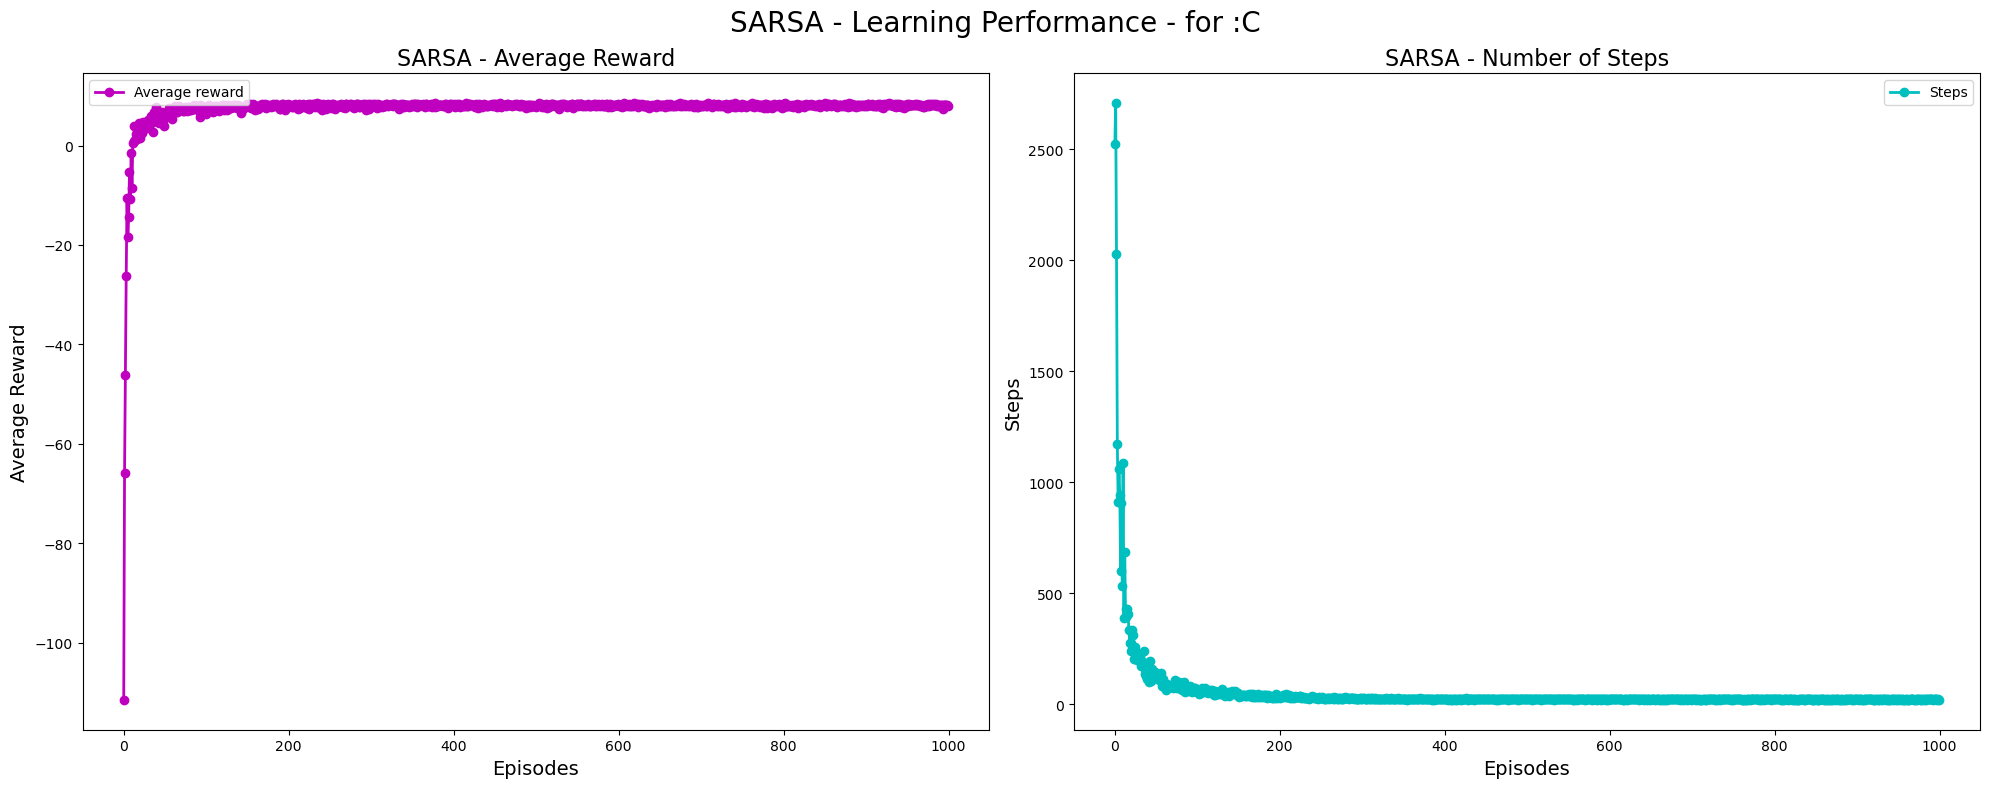

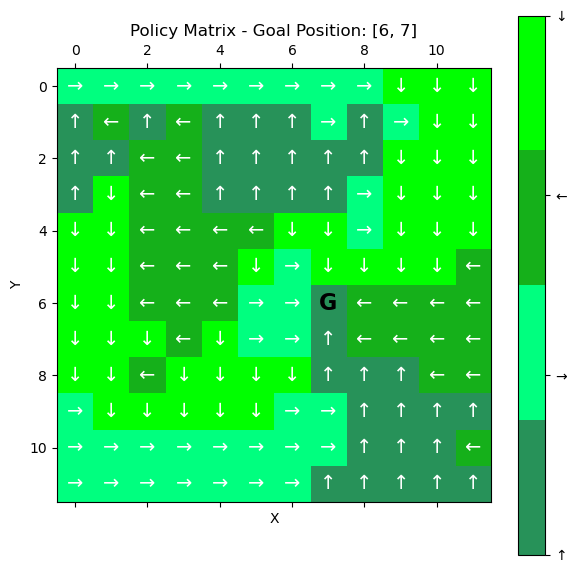

In [18]:
for goal_SARSA in ['A', 'B', 'C']:
    # Get the goal position from the goal_positions dictionary
    goal_pos_SARSA = goal_positions.get(goal_SARSA, [0, 11])
    
    # Run 50 independent SARSA run
    episode_data_list_SARSA = []

    for _ in range(independent_run):
        avg_reward, steps, Q = algo_object_SARSA.episode_run(gamma, alpha, epsilon, episodes, PuddleWorld(), goal_SARSA)
        episode_data_list_SARSA.append((avg_reward, steps, Q))

    # Calculate the average rewards and average steps over the 50 runs
    avg_rewards_SARSA, avg_steps_SARSA = np.zeros([episodes]),np.zeros([episodes])
    
    for i in range(episodes):
        for j in range(len(episode_data_list_SARSA)):
            avg_rewards_SARSA[i] += episode_data_list_SARSA[j][0][i]/len(episode_data_list_SARSA)
            avg_steps_SARSA[i] += episode_data_list_SARSA[j][1][i]/len(episode_data_list_SARSA)

    # Calculate the policy matrix based on the most common action in each state
    policy_matrix_SARSA = np.zeros([12, 12])
    action_counts_SARSA = {0: 0, 1: 0, 2: 0, 3: 0}
    for i in range(12):
        for j in range(12):
            for k in range(len(episode_data_list_SARSA)):
                action_counts_SARSA[np.argmax(episode_data_list_SARSA[k][2], axis=SARSA_axis)[i, j]] += 1
            max_action_SARSA = max(action_counts_SARSA, key=action_counts_SARSA.get)
            action_counts_SARSA = {0: 0, 1: 0, 2: 0, 3: 0}
            policy_matrix_SARSA[i, j] = max_action_SARSA

    # Plot the reward and steps per episode for the current goal using SARSA
    plot_reward_steps(avg_rewards_SARSA, avg_steps_SARSA, episodes, 'SARSA', goal_SARSA)

    # Plot the policy matrix for the current goal using SARSA
    plot_policy(goal_pos_SARSA, policy_matrix_SARSA)

In [19]:
end_time= time.time()

#### Execution Time 

In [20]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 5185.46 seconds


##### Analysis : 
    - 1. Upon an in-depth analysis of our implementation of Q-Learning and SARSA for the Puddle World problem, it is apparent that both algorithms deliver robust performances. Both approaches display evolving optimal policies that vary according to each run and random seed, reflecting the inherent dynamism of reinforcement learning algorithms.

    - 2. However, when we scrutinize the scenarios from a broader perspective, Q-Learning demonstrates a slight edge over SARSA in a subset of iterations and for certain random seeds. This pattern is a testament to the unique attributes of the Q-Learning algorithm and its slightly superior efficacy under these particular circumstances. Yet, it is crucial to consider the environment and the specificities of the problem at hand when choosing between these two reinforcement learning methods.
    
    
##### Conclusion : In conclusion, both Q-Learning and SARSA have shown their effectiveness in solving the Puddle World problem, with each showcasing their strengths under different conditions. This study further underscores the importance of careful algorithm selection in reinforcement learning to best match the nature and requirements of the problem.